# Predicting Shooting Talent for Early NBA Players
## By: Austin Coffelt

**Problem: Who were the best shooters of the Pre-Three Point (Before 1980) era of the NBA?**

The NBA is currently in it's post data revolution phase, where almost everything on the court can be quantified into a number for simplicity. Since 2000, we have reliable play-by-play data for every player in every game, showing us everything we could possibly quantify. This has made player comparison easier, and analyst fall into less and less logical fallacies when evaluating players. Since 2012, the Most Valuable Player award tracks very closely with the major one-number metrics for player impact. The goal of this project is to help bring this data driven approach to the past, transforming the way we think about historical player evaluation. 

I decided to specifically focus on enlightening the area of shooting talent. Since 2000, we have reliable data on where players shot from and the percentage on those shots. I am interested in what a player shoots on jump shots, which for simplicity we will define as from 10+ft away from the basket. **Using data that would be availiable in the pre-Three point era, I will build two predictive models to predict the percentage of field goal attempts that are jump shots and the percentage that players shoot on those shots.**

In [338]:
import pandas as pd
import numpy as np

from scipy.stats import boxcox
from sklearn.preprocessing import scale 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Data Collection and Exploratory Data Analysis

My training dataset consists of per/36 minute box score stats, meaning these stats are normalized for playing time, and shooting data from the years 2000 - 2024. My possible predictors are:
- **Player Age**
- **FGA (Field Goal Attempts):** How many shots a person takes per 36 minutes of playing time
- **FG% (Field Goal Percentage):** What percentage of their shots a player makes
- **FTA (Free Throw Attempts):** How many free throws (what happens when a person is fouled) a player takes per 36 minutes of playing time
- **FT% (Free Throw Percentage):** What percentage of their free throws a player makes
- **TRB (Total Rebounds):** How many rebounds (count of who gets the ball after a missed field goal) a player grabs per 36 minutes
- **AST (Assists):** How many assists (when you pass it to a player who makes a field goal) a player has per 36 minutes
- **PF (Personal Fouls):** How many fouls a player commits per 36 minutes
- **PTS (Points):** How many points a player scores per 36 minutes
- **Pos (Position):** There are 5 positions in basketball (Center, Power Forward, Small Forward, Shooting Guard, Point Guard)

These are the only stats availiable consistently throughout the early period of the NBA, which is why I chose them to be my predictors.

My outcome variables are:
- **Percentage of FGA that are jump shots (shortened to Perc Jump throughout the project)**
- **Jumpshot Percentage (shortened to Jump Perc)**

Because of the way this data is collected (each year has its own box score and shooting table, meaning I have 48 individual csv), I decided to just look at 2024 for my exploratory data analysis. While the means might change year to year, especially with shooting percentages, the underlying distribution should not change.

In [3]:
shooting2024 = pd.read_csv('NBA Shooting Data/NBA Shooting Data 2024 - Sheet1.csv')
boxScore2024 = pd.read_csv('Per_36 Box Score Data/NBA Per_36 Box Score Data 2024 - Sheet1.csv')

In [5]:
shooting2024['percJumpshot'] = shooting2024['10-16 (% of FGA)'] + shooting2024['16-3P (% of FGA)'] + shooting2024['3P (% of FGA)']
shooting2024['jumpshotPercentage'] = (shooting2024['10-16%'] * (shooting2024['10-16 (% of FGA)'] / shooting2024['percJumpshot'])) + (shooting2024['16-3P%'] * (shooting2024['16-3P (% of FGA)'] / shooting2024['percJumpshot'])) + (shooting2024['3P%'] * (shooting2024['3P (% of FGA)'] / shooting2024['percJumpshot']))

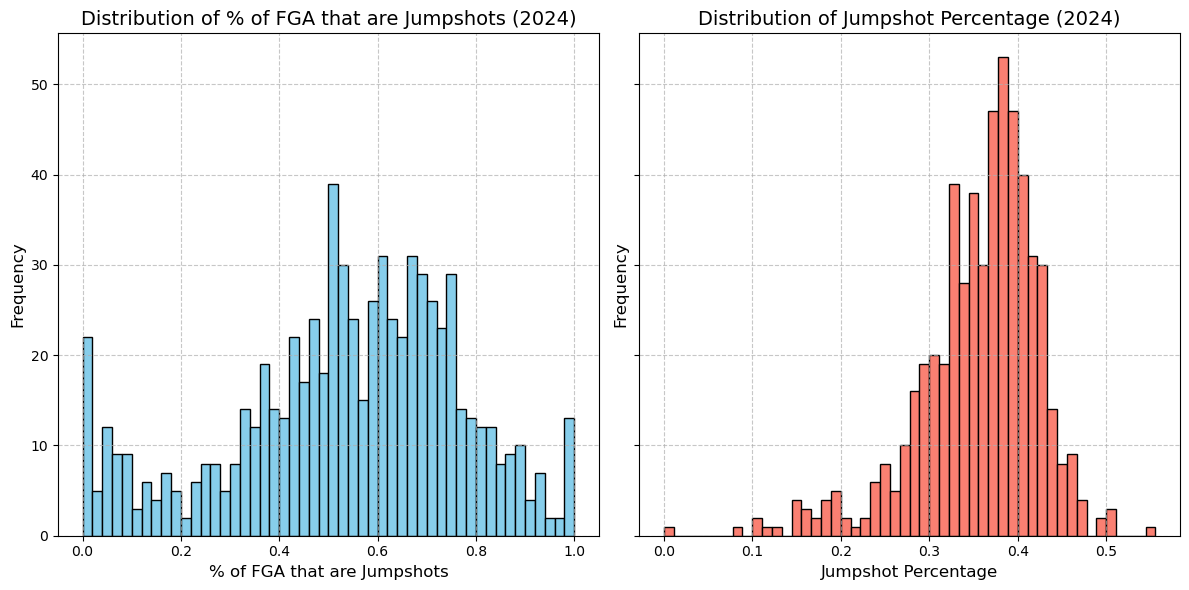

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(12, 6))

# Plot the first histogram
ax1.hist(shooting2024['percJumpshot'], bins=50, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of % of FGA that are Jumpshots (2024)', fontsize=14)
ax1.set_xlabel('% of FGA that are Jumpshots', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot the second histogram
ax2.hist(shooting2024['jumpshotPercentage'], bins=50, color='salmon', edgecolor='black')
ax2.set_title('Distribution of Jumpshot Percentage (2024)', fontsize=14)
ax2.set_xlabel('Jumpshot Percentage', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('histograms.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

Here we have the two distributions for our outcome variables for the year 2024. Percentage of Jumpshots is the only continuous variable that is not normally or skewed normally distributed. This is due to the fact that there are a significant amount of players that never take any jumpshots. Jumpshot percentage is a skewed normal distribution with a mean just shy of 0.4.

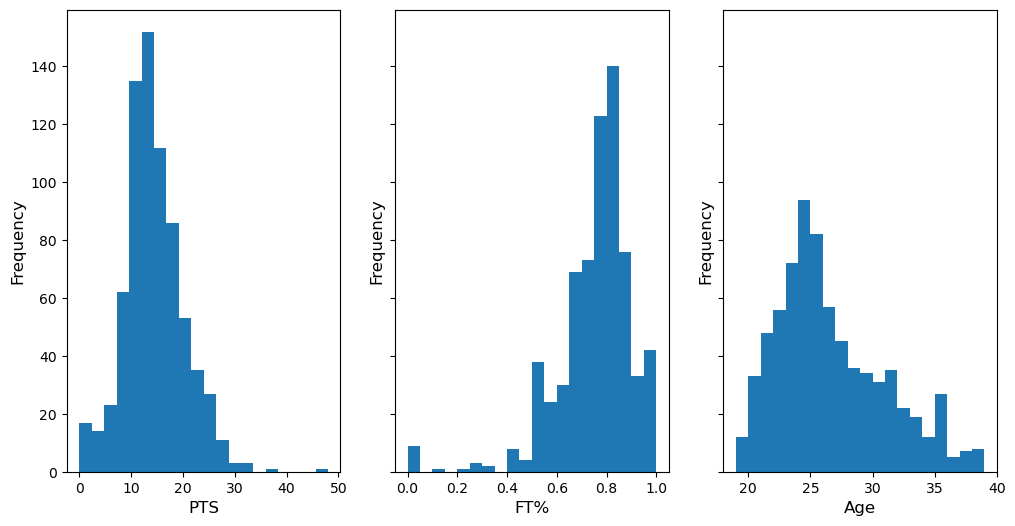

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize=(12, 6))

ax1.hist(boxScore2024['PTS'], bins = 20)
ax1.set_xlabel('PTS', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)

ax2.hist(boxScore2024['FT%'], bins = 20)
ax2.set_xlabel('FT%', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)

ax3.hist(boxScore2024['Age'], bins = 20)
ax3.set_xlabel('Age', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)

plt.show()

Here I chose 3 of my predictors to get accross the overall point that all of my continuous variables are normal or skewed normal. PTS is slightly skewed normal with a mean of around 15. FT% is also skewed normal with a mean of 0.8. Age is skewed normal with a mean of 25. 

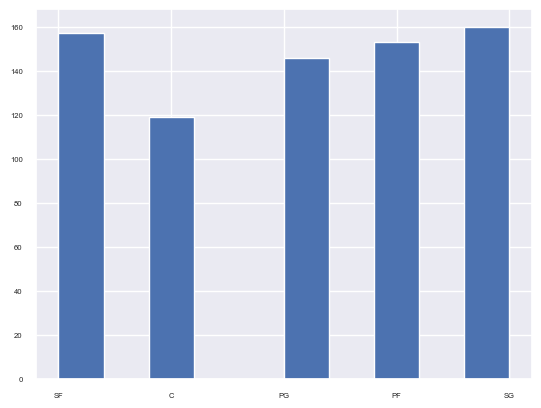

In [341]:
plt.hist(boxScore2024['Pos'])
plt.show()

This is the distribution of positions in the league. There are fewer centers in the league than any other position, with the other 4 being around the same amount as each other.

# Data Pre-Processing/Feature Engineering

Below is the general preprocessing I had to do before getting to the model building and creation.

### Removing observations
I had to remove observations with '2TM', '3TM', etc., because these players are double counted in the dataset. They have the stats with each team in the data as well as their total stats for the season. I also removed any players from the data that did not play at least 375 minutes (about 15 games worth). NBA stats can be influenced by noise over a few games/minutes, so I wanted to only predict on stats I were confident in being a good representation of the players.

### Get Dummies
I got dummy variables for all of the positions, dropping the first to avoid multicolinearity (it dropped center)

### Centering and Scaling
I centered and scaled every continuous variable (both predictors and outcomes) to their year. I did it this way because as basketball has evolved, the players have become more efficient. This means that if I centered and scaled the variables all at once, the distribution would have all the early 2000s years to the left and the more recent years to the right, which would unfairly represent the relative skill level of the players. 

In [213]:
def data_pre_processing(year):
    # Read in the csvs
    boxScore = pd.read_csv(f"Per_36 Box Score Data/NBA Per_36 Box Score Data {year} - Sheet1.csv")
    shooting = pd.read_csv(f"NBA Shooting Data/NBA Shooting Data {year} - Sheet1.csv")

    # Remove totals for traded players (Dont double count them)
    boxScore = boxScore[(boxScore['Team'] != '2TM') | (boxScore['Team'] != '3TM') | (boxScore['Team'] != '4TM') | (boxScore['Team'] != '5TM')]
    shooting = shooting[(shooting['Team'] != '2TM') | (shooting['Team'] != '3TM') | (shooting['Team'] != '4TM') | (shooting['Team'] != '5TM')]

    # Stats become predictive after 10 - 15 games, so remove small sample sizes
    boxScore = boxScore[boxScore['MP'] > 375]
    shooting = shooting[shooting['MP'] > 375]
    
    # drop unneeded columns
    shooting = shooting.drop(['Rk', 'Age', 'Pos', 'G', 'GS', 'MP', 'FG%', 'avgDistance', '2P (% of FGA)', 
                              '0-3 (% of FGA)', '3-10 (% of FGA)', '2P%', '0-3%', '3-10%', '2P', '3P', 
                              '%FGA', '#', '%3PA', '3P%.1', 'Att.', 'Md.', 'Awards', '-9999'], axis = 1)
    
    # find percentage of shots that are jumpshots and what the players shoot on those shots
    shooting['percJumpshot'] = shooting['10-16 (% of FGA)'] + shooting['16-3P (% of FGA)'] + shooting['3P (% of FGA)']
    shooting['jumpshotPercentage'] = (shooting['10-16%'] * (shooting['10-16 (% of FGA)'] / shooting['percJumpshot'])) + (shooting['16-3P%'] * (shooting['16-3P (% of FGA)'] / shooting['percJumpshot'])) + (shooting['3P%'] * (shooting['3P (% of FGA)'] / shooting['percJumpshot']))
    
    # merge the 2 columns
    df = pd.merge(boxScore, shooting, on = ['Player', 'Team'], how = 'left')

    # drop unneeded columns
    df = df.drop(['Rk', 'Player', 'Team', 'G', 'GS', 'MP', 'FG', '3P', '3PA', '3P%_x', '2P', '2PA', '2P%', 'eFG%', 'FT',
                  'ORB', 'DRB', 'STL', 'BLK', 'TOV', 'Awards', 'Player-additional', '10-16 (% of FGA)', '16-3P (% of FGA)',
                  '3P (% of FGA)', '10-16%', '16-3P%', '3P%_y'], axis = 1)

    # get dummies for Position
    df = pd.get_dummies(df, drop_first = True, dtype = 'int')

    # center and scale predictors and outcome
    posIdx = df.apply(lambda x: np.all(x > 0))
    posIdx[-4:] = False
    posIdx = np.array(posIdx)
    
    df.loc[:, posIdx] = df.iloc[:, posIdx].apply(lambda x: boxcox(x + 0.01)[0])
    df.iloc[:, :-4] = df.iloc[:, :-4].apply(lambda x: scale(x))
    
    return df

In [215]:
# read in each individual year
df2000 = data_pre_processing(2000)
df2001 = data_pre_processing(2001)
df2002 = data_pre_processing(2002)
df2003 = data_pre_processing(2003)
df2004 = data_pre_processing(2004)
df2005 = data_pre_processing(2005)
df2006 = data_pre_processing(2006)
df2007 = data_pre_processing(2007)
df2008 = data_pre_processing(2008)
df2009 = data_pre_processing(2009)
df2010 = data_pre_processing(2010)
df2011 = data_pre_processing(2011)
df2012 = data_pre_processing(2012)
df2013 = data_pre_processing(2013)
df2014 = data_pre_processing(2014)
df2015 = data_pre_processing(2015)
df2016 = data_pre_processing(2016)
df2017 = data_pre_processing(2017)
df2018 = data_pre_processing(2018)
df2019 = data_pre_processing(2019)
df2020 = data_pre_processing(2020)
df2021 = data_pre_processing(2021)
df2022 = data_pre_processing(2022)
df2023 = data_pre_processing(2023)
df2024 = data_pre_processing(2024)

In [216]:
df2024.head()

,Age,FGA,FG%,FTA,FT%,TRB,AST,PF,PTS,percJumpshot,jumpshotPercentage,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,1.540352,1.082234,0.314024,2.122285,0.830795,-0.872903,0.874340,-1.235303,1.361855,0.496209,0.932216,0,0,1,0
1,0.216192,0.286073,1.590943,1.264266,-0.772113,1.929609,1.756248,0.315104,0.852870,-1.645574,1.126146,0,0,0,0
2,-0.818270,0.795683,-0.188267,0.357066,0.644554,-0.632328,0.874340,-0.655007,0.733128,0.260289,0.264052,0,1,0,0
3,0.216192,1.082234,-0.373979,0.770072,0.358563,-0.521511,0.323608,-1.912110,0.969377,0.611856,0.366690,0,0,1,0
4,-1.450682,1.489298,-0.059275,2.054633,-0.578244,0.482005,1.013476,-1.082505,1.421549,0.005865,0.114580,1,0,0,0


In [219]:
df2024.columns

Index(['Age', 'FGA', 'FG%', 'FTA', 'FT%', 'TRB', 'AST', 'PF', 'PTS',
       'percJumpshot', 'jumpshotPercentage', 'Pos_PF', 'Pos_PG', 'Pos_SF',
       'Pos_SG'],
      dtype='object')

In [221]:
# concatinate all of the years into a single dataframe
df = pd.concat([df2000, df2001, df2002, df2003, df2004, df2005, df2006, df2007, df2008, df2009, df2010,
                df2011, df2012, df2013, df2014, df2015, df2016, df2017, df2018, df2019, df2020, df2021,
                df2022, df2023, df2024])

df.head()

,Age,FGA,FG%,FTA,FT%,TRB,AST,PF,PTS,percJumpshot,jumpshotPercentage,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,-0.335046,1.630040,0.319601,-0.022156,0.795720,-0.181355,0.913331,-1.985002,1.382453,0.568160,0.831030,0,0,1,0
1,0.768414,1.778916,0.143809,0.623534,-0.173834,-0.100686,1.782472,-1.823158,1.721239,0.057159,-0.414500,0,1,0,0
2,0.351143,0.811981,-0.114956,0.623534,1.404723,-0.937717,0.515529,-1.669773,0.775377,0.453793,0.614600,0,0,1,0
3,-1.109852,1.600173,1.070183,0.677294,0.146109,1.391362,0.877254,-1.252623,1.676510,0.092170,1.047818,1,0,0,0
4,-1.109852,0.811981,0.473643,1.501009,0.659092,1.047278,0.226062,-0.775497,1.221613,-0.689955,-0.171181,0,0,1,0


In [223]:
df.shape

(10516, 15)

### Missing Values
I had several values missing in the Jumpshot Percentage column, due to a person not taking a jumpshot during that season. My 2 choices there are to fill the nans with 0s (because a person who does not shoot likely cannot shoot) or to remove them all together. I decided to go with the latter because while estimating Jumpshot Percentage, the 0 values weighed down my predictions, making the predictions for the rest of the set worse to capture the players that are not shooting. I would rather more accurately estimate the best shooters then better capture the worst, and removing the nan values allows me to do that. I kept the observations with nan values when predicting percentage of jumpshots, but dropped them when predicting jumpshot percentage.

In [225]:
df.isna().sum()

Age                     0
FGA                     0
FG%                     0
FTA                     0
FT%                     0
TRB                     0
AST                     0
PF                      0
PTS                     0
percJumpshot            0
jumpshotPercentage    943
Pos_PF                  0
Pos_PG                  0
Pos_SF                  0
Pos_SG                  0
dtype: int64

In [227]:
percJump = df.drop('jumpshotPercentage', axis = 1)
jumpshotPerc = df

In [229]:
percJump.isna().sum()

Age             0
FGA             0
FG%             0
FTA             0
FT%             0
TRB             0
AST             0
PF              0
PTS             0
percJumpshot    0
Pos_PF          0
Pos_PG          0
Pos_SF          0
Pos_SG          0
dtype: int64

In [231]:
jumpshotPerc = jumpshotPerc.dropna()

In [233]:
jumpshotPerc.isna().sum()

Age                   0
FGA                   0
FG%                   0
FTA                   0
FT%                   0
TRB                   0
AST                   0
PF                    0
PTS                   0
percJumpshot          0
jumpshotPercentage    0
Pos_PF                0
Pos_PG                0
Pos_SF                0
Pos_SG                0
dtype: int64

In [235]:
print(len(percJump))
print(len(jumpshotPerc))

10516
9573


After removing observations with nan values, we see that the dataset we will be predicting percentage of jumpshot on has about 1000 observations more than the other dataset.

In [237]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Percentage of FGAs that are Jumpshots

### Now we will split our project up into its 2 sides, the first being percentage of jumpshots

In [38]:
# split into outcome and predictors
outcomePercJump = pd.DataFrame(percJump['percJumpshot'])
predictorsPercJump = percJump.drop('percJumpshot', axis = 1)

In [40]:
predictorsPercJump.head()

,Age,FGA,FG%,FTA,FT%,TRB,AST,PF,PTS,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,-0.335046,1.630040,0.319601,-0.022156,0.795720,-0.181355,0.913331,-1.985002,1.382453,0,0,1,0
1,0.768414,1.778916,0.143809,0.623534,-0.173834,-0.100686,1.782472,-1.823158,1.721239,0,1,0,0
2,0.351143,0.811981,-0.114956,0.623534,1.404723,-0.937717,0.515529,-1.669773,0.775377,0,0,1,0
3,-1.109852,1.600173,1.070183,0.677294,0.146109,1.391362,0.877254,-1.252623,1.676510,1,0,0,0
4,-1.109852,0.811981,0.473643,1.501009,0.659092,1.047278,0.226062,-0.775497,1.221613,0,0,1,0


In [42]:
outcomePercJump.head()

,percJumpshot
0,0.568160
1,0.057159
2,0.453793
3,0.092170
4,-0.689955


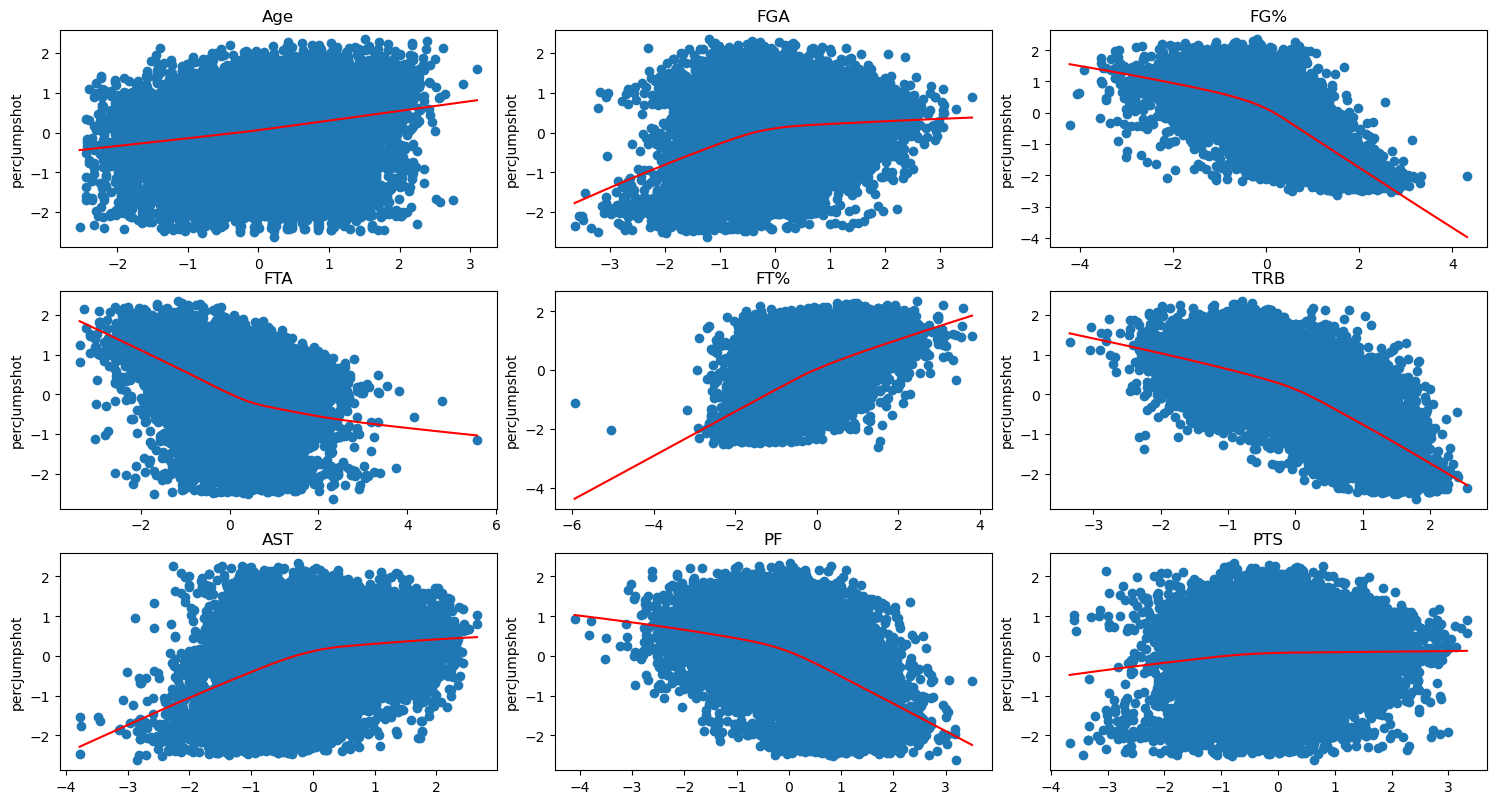

In [44]:
# use lowess to check for linearity
import statsmodels.api as sm

# predictorsContin contains the 9 continuous predictor columns
predictorsContinPercJump = predictorsPercJump[predictorsPercJump.columns[:-4]]

# Run local smoother lowess
lowess = sm.nonparametric.lowess

# Draw scatterplots
nrows = 3
ncols = 3

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))
fig.tight_layout()

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Iterate through each column and plot
for i, col in enumerate(predictorsContinPercJump.columns):
    if i >= nrows * ncols:
        break  # Stop if we exceed the number of subplots

    X_graph = predictorsContinPercJump[col]
    z = lowess(np.squeeze(outcomePercJump), np.squeeze(X_graph), frac=0.9)
    
    axs[i].scatter(X_graph, outcomePercJump)
    axs[i].plot(z[:, 0], z[:, 1], 'r')
    axs[i].set_title(col)
    axs[i].set_ylabel(outcomePercJump.columns[0])

# Hide any unused subplots
for j in range(i + 1, nrows * ncols):
    axs[j].axis('off')

plt.show()

We see in our lowess plots that we have pretty clean data with clear trends. This bodes well for our ability to correctly predict percentage of jumpshots. Our best trends are the clear negative relationship between rebounds and perc jump and the clear positive relationship between FT% and perc jump.

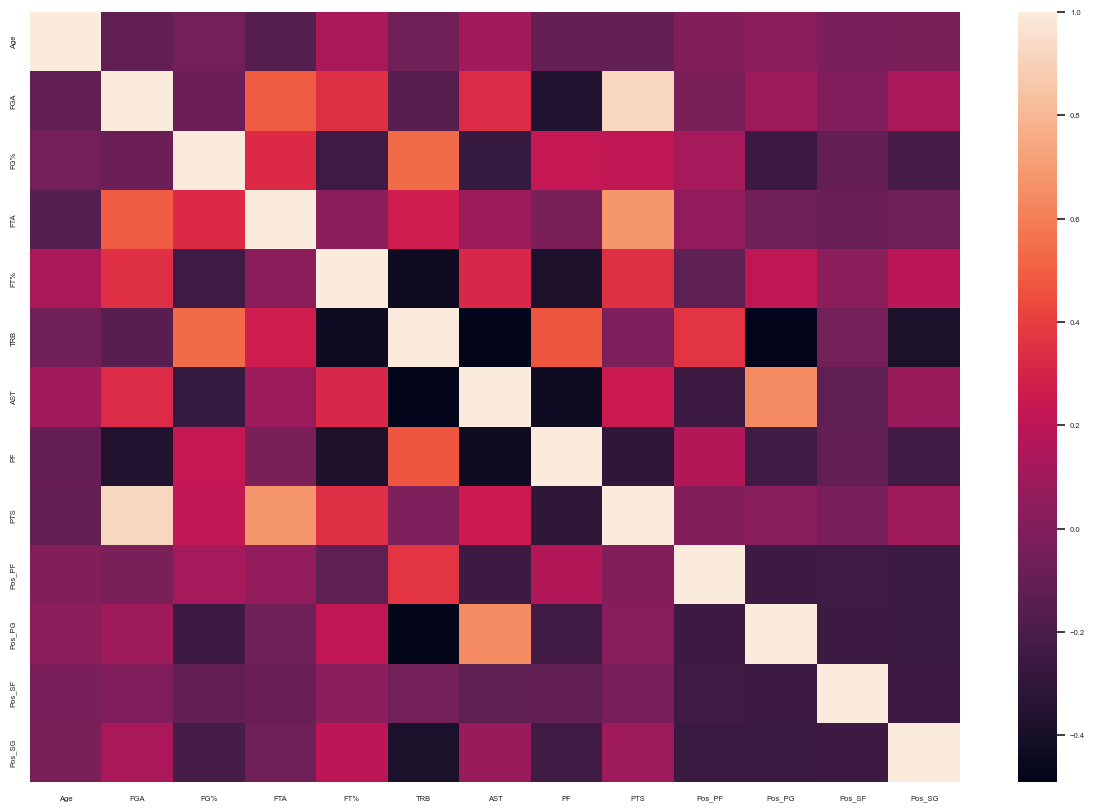

In [45]:
# derive correlation matrix 
corrDataPercJump = predictorsPercJump.corr()
corrDataPercJump.dropna()

# visualize correlation matrix

plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)
sns.heatmap(corrDataPercJump)
plt.show()

In [48]:
corrDataPercJump

,Age,FGA,FG%,FTA,FT%,TRB,AST,PF,PTS,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Age,1.000000,-0.115152,-0.043251,-0.159943,0.139110,-0.064507,0.104042,-0.098810,-0.109827,0.002284,0.028366,-0.026281,-0.023533
FGA,-0.115152,1.000000,-0.079687,0.491546,0.352200,-0.150753,0.332978,-0.356516,0.920880,-0.019352,0.092009,-0.012489,0.144019
FG%,-0.043251,-0.079687,1.000000,0.324854,-0.243317,0.534662,-0.278685,0.229951,0.218220,0.121688,-0.254940,-0.109919,-0.213582
FTA,-0.159943,0.491546,0.324854,1.000000,0.032762,0.269722,0.089830,-0.021440,0.679293,0.051889,-0.054687,-0.084219,-0.067788
FT%,0.139110,0.352200,-0.243317,0.032762,1.000000,-0.436214,0.313323,-0.378125,0.352601,-0.124905,0.208842,0.030942,0.197724
TRB,-0.064507,-0.150753,0.534662,0.269722,-0.436214,1.000000,-0.490200,0.470777,-0.017238,0.366251,-0.485519,-0.051683,-0.382993
AST,0.104042,0.332978,-0.278685,0.089830,0.313323,-0.490200,1.000000,-0.435146,0.252924,-0.251137,0.643600,-0.124623,0.085841
PF,-0.098810,-0.356516,0.229951,-0.021440,-0.378125,0.470777,-0.435146,1.000000,-0.305574,0.161984,-0.239798,-0.113630,-0.235510
PTS,-0.109827,0.920880,0.218220,0.679293,0.352601,-0.017238,0.252924,-0.305574,1.000000,0.000684,0.019457,-0.032163,0.092112
Pos_PF,0.002284,-0.019352,0.121688,0.051889,-0.124905,0.366251,-0.251137,0.161984,0.000684,1.000000,-0.255114,-0.244927,-0.260401


### Correlation
We see in our data strong correlation between FGA and PTS. My algorithm below will remove the predictor that correlates too strongly to the rest of the variables.

In [50]:
def eliminateCorr(data, threshold):

    corrData = np.abs(data.corr())
    
    while ((corrData < 1) & (corrData > threshold)).any().any():
    
        bigCorr = 0
        maxCol = ''
        maxInd = ''

        # find the biggest piecewise correlation
        for col in corrData.columns:
            for idx in list(corrData.index):
                if (corrData.loc[idx, col] > bigCorr) & (corrData.loc[idx, col] != 1):
                    bigCorr = corrData.loc[idx, col]
                    maxCol = col
                    maxIdx = idx

        # drop the column with the highest piecewise correlation
        if (np.mean(corrData.loc[maxIdx, :]) > np.mean(corrData.loc[:, maxCol])):
            corrData.drop(maxIdx, axis = 0, inplace = True)
            corrData.drop(maxIdx, axis = 1, inplace = True)
        else:
            corrData.drop(maxCol, axis = 0, inplace = True)
            corrData.drop(maxCol, axis = 1, inplace = True)

    return data[corrData.columns]

In [52]:
predictorsPercJumpReduced = eliminateCorr(predictorsPercJump, 0.75)

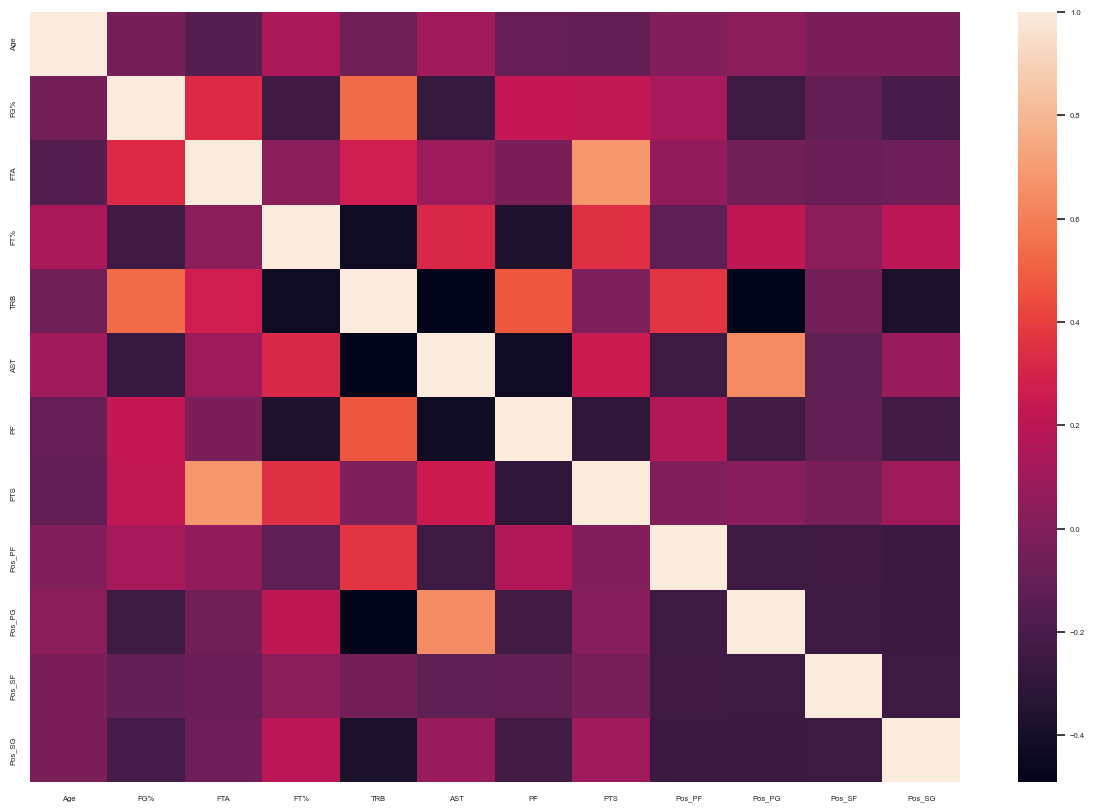

In [54]:
# derive correlation matrix 
corrDataPercJumpReduced = predictorsPercJumpReduced.corr()
corrDataPercJumpReduced.dropna()

# visualize correlation matrix

plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)
sns.heatmap(corrDataPercJumpReduced)
plt.show()

We can see that the algorithm chose to remove FGA over PTS.

In [56]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets

xTrainPercJump, xTestPercJump, yTrainPercJump, yTestPercJump = train_test_split(predictorsPercJumpReduced, outcomePercJump, test_size=0.2, random_state = 1)

In [58]:
# designate cvParam to use for less complex models
cvParam = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1)

I decided to use repeated k-fold cross-validation for the 3 less complex models as it does not take very long to do the extra repeats for these models and we can never have too much certainty with our estimations. With the more complex, time-consuming models, I used plain k-fold cross-validation, with the number of folds being 5.

# Model Building and Evaluation

### Linear Model

In [60]:
# instantiate Linear Regression
lmPercJump = LinearRegression()

# calculate cv scores
cvScoresPercJumpLM = cross_validate(lmPercJump, xTrainPercJump, yTrainPercJump, cv = cvParam, scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True)
rmsePercJumpLM = np.sqrt(-1 * np.mean(cvScoresPercJumpLM['train_neg_mean_squared_error']))

print('train set RMSE: ' + str(rmsePercJumpLM))
print('train set r2: ' + str(np.mean(cvScoresPercJumpLM['train_r2'])))

train set RMSE: 0.46344515191888025
train set r2: 0.7849686726572831


In [62]:
# test against the test set
lmPercJump.fit(xTrainPercJump, yTrainPercJump)
yPercJumpPredLm = lmPercJump.predict(xTestPercJump)

testPercJumpR2lm = r2_score(yTestPercJump, yPercJumpPredLm)
testPercJumpRMSElm = np.sqrt(mean_squared_error(yTestPercJump, yPercJumpPredLm))

print('test set RMSE: '+str(testPercJumpRMSElm))
print('test set r2: '+str(testPercJumpR2lm))

test set RMSE: 0.45678209789260377
test set r2: 0.7921667757909524


An interesting observation in our cross-validation is that the linear model performs better on the testing set than the training set. This likely means that our testing set is more linear in its parameters than the training set, and has no impact on our ability to correctly estimate our model.

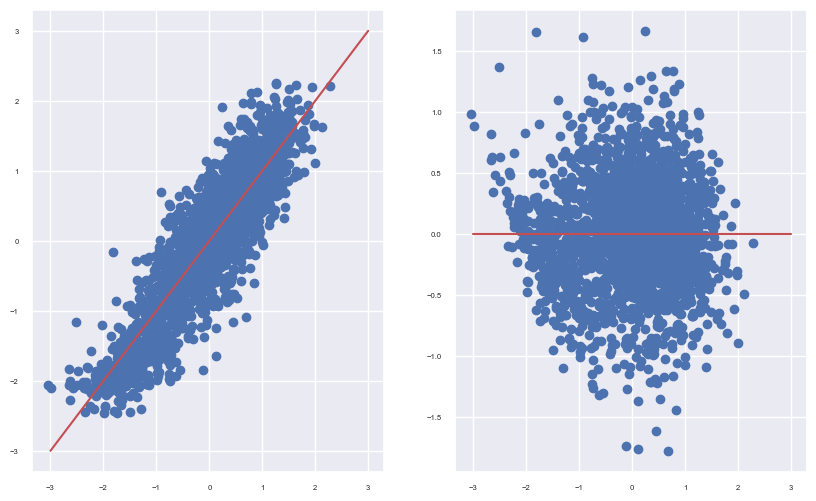

In [64]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yPercJumpPredLm, yTestPercJump)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yPercJumpPredLm, yTestPercJump - yPercJumpPredLm)
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

In our Pred vs Actual and residuals graphs, we see pretty good results, with our predictions matching up with the actual data pretty well. There are some instances of heteroskedasticity (residuals not evenly spread accross the 4 quadrants) that give an indication that a linear model may not be the best model for this dataset.

### PLS Regression

Here I try another linear model, a Partial Least Squares regression, in hope that we can maybe improve our predictions as well as our efficiency by summarizing our predictors. I was able to use around 4 components to get roughly the same outcome as the linear model, imporving efficiency. As to be expected there was no improvement in accuracy, and with few predictors in the first place, I would choose the more accuate model over PLS.

In [364]:
# instantiate PLS Regression

rmsePercJumpPLS = []
r2PercJumpPLS = []

for i in range(1, 13):
    pls = PLSRegression(n_components = i)
    score = cross_validate(pls, xTrainPercJump, yTrainPercJump, cv = cvParam, scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True)
    rmsePercJumpPLS.append(np.sqrt(-np.mean(score['train_neg_mean_squared_error'])))
    r2PercJumpPLS.append(np.mean(score['train_r2']))

# print minimum RMSE for PLS
print('Minimum RMSE for PLS: ' + str(np.min(rmsePercJumpPLS)))

# number of units used for min RMSE
print('# of components for RMSE PLS: ' + str(np.argmin(rmsePercJumpPLS)))

print('==========================')

# maximum r2 for PLS
print('Maximum r2 for PLS: ' + str(np.max(r2PercJumpPLS)))

# number of units used for max r2
print('# of components for R2 PLS: ' + str(np.argmax(r2PercJumpPLS)))

Minimum RMSE for PLS: 0.46344515191888014
# of components for RMSE PLS: 11
Maximum r2 for PLS: 0.7849686726572831
# of components for R2 PLS: 11


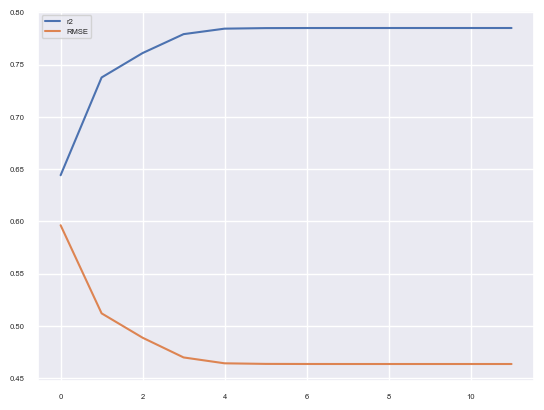

In [365]:
plt.plot(r2PercJumpPLS, label = 'r2')
plt.plot(rmsePercJumpPLS, label = 'RMSE')
plt.legend()
plt.show()

In [368]:
# get predictions
plsPercJump = PLSRegression(n_components = 4)
plsPercJump.fit(xTrainPercJump, yTrainPercJump)
yPercJumpPredPLS = plsPercJump.predict(xTestPercJump)

testPercJumpR2pls = r2_score(yTestPercJump, yPercJumpPredPLS)
testPercJumpRMSEpls = np.sqrt(mean_squared_error(yTestPercJump, yPercJumpPredPLS))

print('test RMSE: '+str(testPercJumpRMSEpls))
print('test r2: '+str(testPercJumpR2pls))

test RMSE: 0.4614533013786245
test r2: 0.7878942996785111


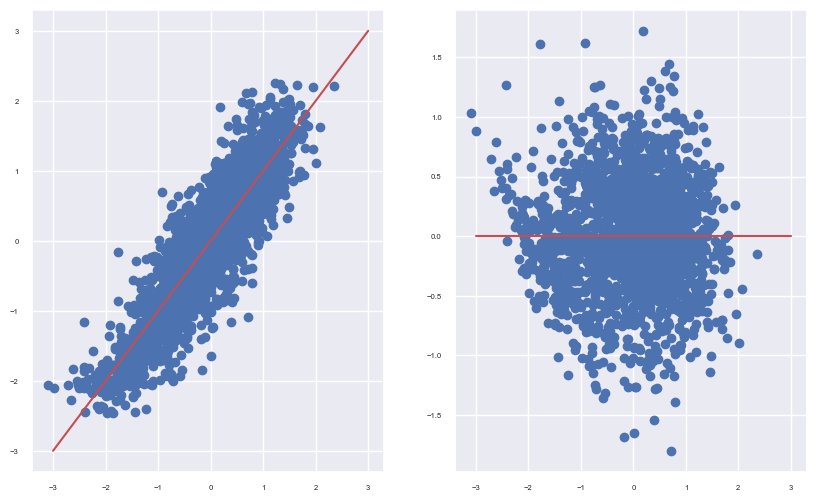

In [370]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yPercJumpPredPLS, yTestPercJump)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yPercJumpPredPLS, yTestPercJump - yPercJumpPredPLS)
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

### Ridge Regression
I decided to try a ridge regression over lasso and elastic net because I did not want the model to remove any predictors (because I do not have that many), as lasso and elastic net both can do. I used grid search to cross validate the model and to find the most optimal tuning parameter, alpha. Grid search found the best parameter to be 4, though the model still performed about the same as the original linear model.

In [74]:
# Grid Search Ridge Regression
ridgeParam = {'alpha': np.linspace(0, 50, 51)}

gsRidgePercJump = GridSearchCV(Ridge(), ridgeParam, cv = cvParam, scoring = ('r2', 'neg_mean_squared_error'), refit = 'neg_mean_squared_error', return_train_score = True, n_jobs = -1)
gsRidgePercJump.fit(xTrainPercJump, yTrainPercJump)
cvResultsRidgePercJump = pd.DataFrame(gsRidgePercJump.cv_results_)[['params', 'mean_train_r2', 'mean_train_neg_mean_squared_error']]

print('Best Train r2: ' + str(cvResultsRidgePercJump['mean_train_r2'].max()))
print('Best Train RMSE: ' + str(np.sqrt(-1 * (cvResultsRidgePercJump['mean_train_neg_mean_squared_error'].max()))))
print('Best Params: ' + str(gsRidgePercJump.best_params_))

Best Train r2: 0.7849686726572831
Best Train RMSE: 0.4634451519188802
Best Params: {'alpha': 4.0}


In [76]:
# test against the test set
yPercJumpPredRidge = gsRidgePercJump.predict(xTestPercJump)

testPercJumpR2ridge = r2_score(yTestPercJump, yPercJumpPredRidge)
testPercJumpRMSEridge = np.sqrt(mean_squared_error(yTestPercJump, yPercJumpPredRidge))

print('test RMSE: '+str(testPercJumpRMSEridge))
print('test r2: '+str(testPercJumpR2ridge))

test RMSE: 0.4567261159975213
test r2: 0.7922177155490395


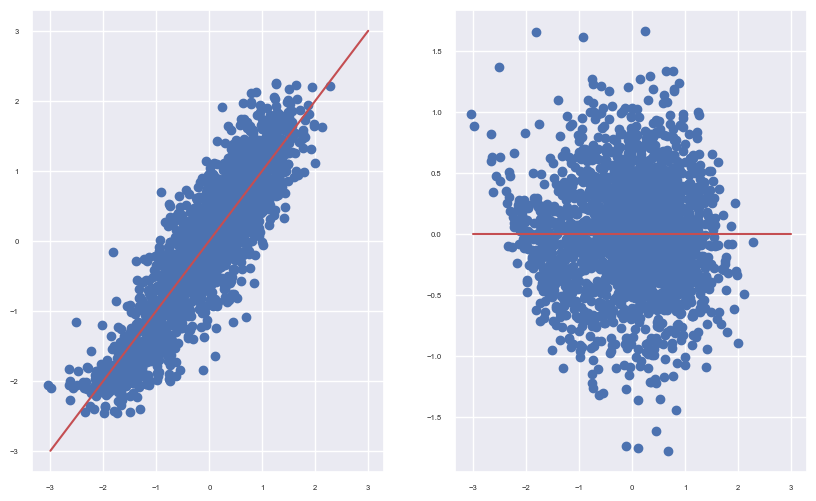

In [78]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yPercJumpPredRidge, yTestPercJump)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yPercJumpPredRidge, yTestPercJump - yPercJumpPredRidge)
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

### Support Vector Machine Regression
With the SVM regression I looked at finding the best values for the kernel, epsilon, and cost (C) parameter. Through the grid search cross-validation, it found the best parameters to be kernel = rbf, epsilon = 0.1, and cost = 1. This model performs better than the 3 linear models I tested previously and is a contender for the best model for our analysis.

In [80]:
# Grid Search SVM model
svmParams = {'kernel': ['poly','rbf'],
             'epsilon': [0.01, 0.05, 0.1, 0.5, 1],
             'C': [0.1, 1, 5, 10, 15, 25]}

gsPercJumpSVM = GridSearchCV(SVR(), svmParams, cv = 5, scoring = ('r2', 'neg_mean_squared_error'), refit = 'neg_mean_squared_error', return_train_score = True, n_jobs = -1)
gsPercJumpSVM.fit(xTrainPercJump, np.ravel(yTrainPercJump))

# get cv scores
cvResultsSVMPercJump = pd.DataFrame(gsPercJumpSVM.cv_results_)[['params', 'mean_train_r2', 'mean_train_neg_mean_squared_error']]

print('Best r2: ' + str(cvResultsSVMPercJump.loc[(cvResultsSVMPercJump['params'] == gsPercJumpSVM.best_params_), 'mean_train_r2']))
print('Best RMSE: ' + str(np.sqrt(-1 * (cvResultsSVMPercJump.loc[(cvResultsSVMPercJump['params'] == gsPercJumpSVM.best_params_), 'mean_train_neg_mean_squared_error']))))
print('Best Params: ' + str(gsPercJumpSVM.best_params_))

Best r2: 15    0.847281
Name: mean_train_r2, dtype: float64
Best RMSE: 15    0.390568
Name: mean_train_neg_mean_squared_error, dtype: float64
Best Params: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}


In [82]:
# test against the test set
yPercJumpPredSVR = gsPercJumpSVM.predict(xTestPercJump)

testPercJumpR2svr = r2_score(yTestPercJump, yPercJumpPredSVR)
testPercJumpRMSEsvr = np.sqrt(mean_squared_error(yTestPercJump, yPercJumpPredSVR))

print('test RMSE: '+str(testPercJumpRMSEsvr))
print('test r2: '+str(testPercJumpR2svr))

test RMSE: 0.4267417427996195
test r2: 0.8186042621283562


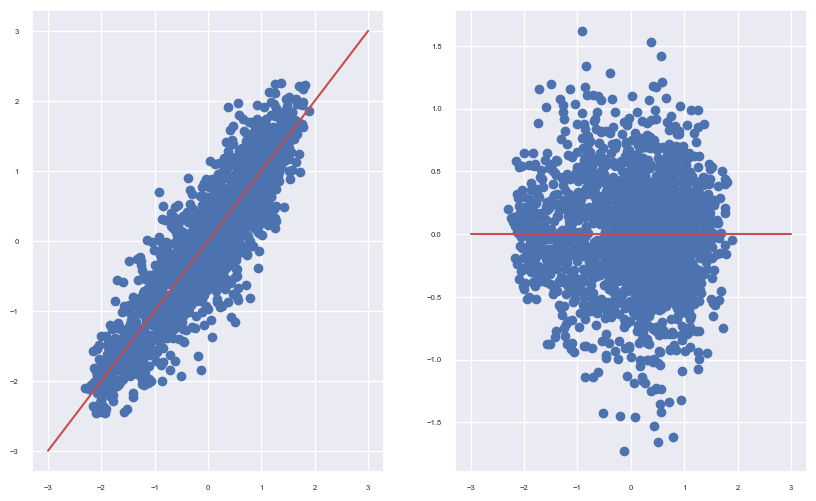

In [84]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yPercJumpPredSVR, yTestPercJump)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yPercJumpPredSVR, (yTestPercJump - yPercJumpPredSVR.reshape(yTestPercJump.shape)))
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

### MLP (Neural Network) Regressor
With the neural network regressor, I used grid search to find the optimal values for the hidden_layer_sizes (different layers and units in the layers) and alpha parameters. It found the best parameters to be hidden_layer_size = (100,) and alpha = 0.1. This model is also a major contender for best model.

In [86]:
# Grid Search MLPRegressor
mlpParams = {'hidden_layer_sizes': [(10, ), (50, ), (100, ), (50, 20, ), (100, 50, ), (50, 30, 10, ), (100, 50, 20, ), (50, 30, 20, 10, )],
            'alpha': [0.00, 0.0001, 0.001, 0.01, 0.1, 1],
            'max_iter': [1000]}

gsPercJumpMLP = GridSearchCV(MLPRegressor(), mlpParams, cv = 5, scoring = ('r2', 'neg_mean_squared_error'), refit = 'neg_mean_squared_error', return_train_score = True, n_jobs = -1)
gsPercJumpMLP.fit(xTrainPercJump, np.ravel(yTrainPercJump))

# get cv scores
cvResultsMLPPercJump = pd.DataFrame(gsPercJumpMLP.cv_results_)[['params', 'mean_train_r2', 'mean_train_neg_mean_squared_error']]

print('Best r2: ' + str(cvResultsMLPPercJump.loc[(cvResultsMLPPercJump['params'] == gsPercJumpMLP.best_params_), 'mean_train_r2']))
print('Best RMSE: ' + str(np.sqrt(-1 * (cvResultsMLPPercJump.loc[(cvResultsMLPPercJump['params'] == gsPercJumpMLP.best_params_), 'mean_train_neg_mean_squared_error']))))
print('Best Params: ' + str(gsPercJumpMLP.best_params_))

Best r2: 34    0.838186
Name: mean_train_r2, dtype: float64
Best RMSE: 34    0.402028
Name: mean_train_neg_mean_squared_error, dtype: float64
Best Params: {'alpha': 0.1, 'hidden_layer_sizes': (100,), 'max_iter': 1000}


In [88]:
# test against the test set
yPercJumpPredMLP = gsPercJumpMLP.predict(xTestPercJump)

testPercJumpR2mlp = r2_score(yTestPercJump, yPercJumpPredMLP)
testPercJumpRMSEmlp = np.sqrt(mean_squared_error(yTestPercJump, yPercJumpPredMLP))

print('test RMSE: '+str(testPercJumpRMSEmlp))
print('test r2: '+str(testPercJumpR2mlp))

test RMSE: 0.4277523298501997
test r2: 0.8177441014029143


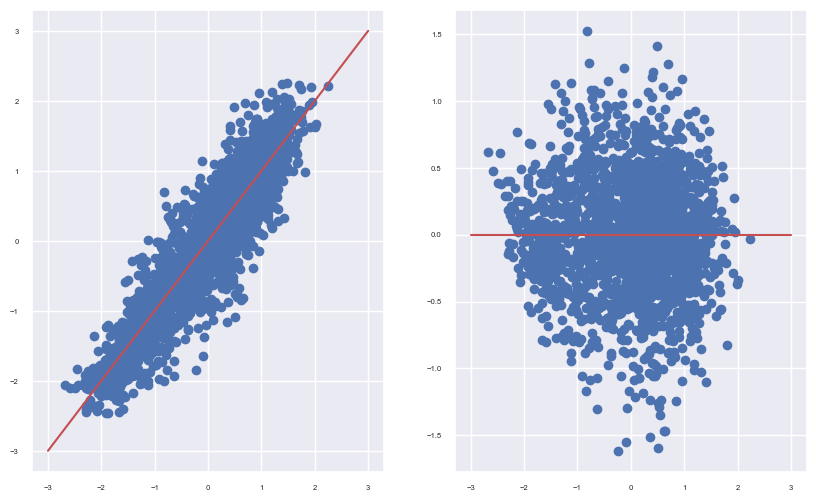

In [90]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yPercJumpPredMLP, yTestPercJump)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yPercJumpPredMLP, yTestPercJump - yPercJumpPredMLP.reshape(yTestPercJump.shape))
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

### Random Forest Regression
With random forest, I grid searched 5 different parameters: n_estimators (number of trees), max_depth (maximum amount of branches), max_features (maximum amount of predictors avaliable to look at at each node), min_samples_leaf (minimum amount of observations on an ending node (leaf node)), min_samples_split (minimum amount of samples to split the data again). The grid search found the optimal parameters and returned them below. Overall performance with the cross-validations and testing shows it peerforming slightly worse than the previous 2 models.

In [133]:
# Grid Search Random Forest Regressor
rfrParams = {'n_estimators': [500, 750, 1000],
             'max_depth': [None, 20, 30, 50],
             'max_features': ['sqrt', 0.5],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [6, 7, 8, 9, 10],
             'random_state': [1],
             'criterion': ['squared_error']}

gsPercJumpRFR = GridSearchCV(RandomForestRegressor(), rfrParams, cv = 5, scoring = ('r2', 'neg_mean_squared_error'), refit = 'neg_mean_squared_error', return_train_score = True, n_jobs = -1)
gsPercJumpRFR.fit(xTrainPercJump, np.ravel(yTrainPercJump))

# get cv scores
cvResultsRFRPercJump = pd.DataFrame(gsPercJumpRFR.cv_results_)[['params', 'mean_train_r2', 'mean_train_neg_mean_squared_error']]

print('Best r2: ' + str(cvResultsRFRPercJump.loc[(cvResultsRFRPercJump['params'] == gsPercJumpRFR.best_params_), 'mean_train_r2']))
print('Best RMSE: ' + str(np.sqrt(-1 * (cvResultsRFRPercJump.loc[(cvResultsRFRPercJump['params'] == gsPercJumpRFR.best_params_), 'mean_train_neg_mean_squared_error']))))
print('Best Params: ' + str(gsPercJumpRFR.best_params_))

Best r2: 377    0.955675
Name: mean_train_r2, dtype: float64
Best RMSE: 377    0.210414
Name: mean_train_neg_mean_squared_error, dtype: float64
Best Params: {'criterion': 'squared_error', 'max_depth': 30, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1000, 'random_state': 1}


In [135]:
# test against the test set
yPercJumpPredRFR = gsPercJumpRFR.predict(xTestPercJump)

testPercJumpR2rfr = r2_score(yTestPercJump, yPercJumpPredRFR)
testPercJumpRMSErfr = np.sqrt(mean_squared_error(yTestPercJump, yPercJumpPredRFR))

print('test RMSE: '+str(testPercJumpRMSErfr))
print('test r2: '+str(testPercJumpR2rfr))

test RMSE: 0.44229178120160373
test r2: 0.8051436496448832


We see here a 15 point difference between the r2 of the train vs the test set. This would normally be considered significant overfitting of our model, which would normally result in poor test set performance. But investigating our grid seach shows there are possible models in the search that would not return as overfit (ex. with leaf at 5, split at 10, and depth at 20, we would see a difference between train and test performance of around 5 r2 points, but the test set performance would be worse), meaning that the nominally overfit model that returned as our best model is our best model with our test set. This is common with tree based models, as we will see with our XGBoost.

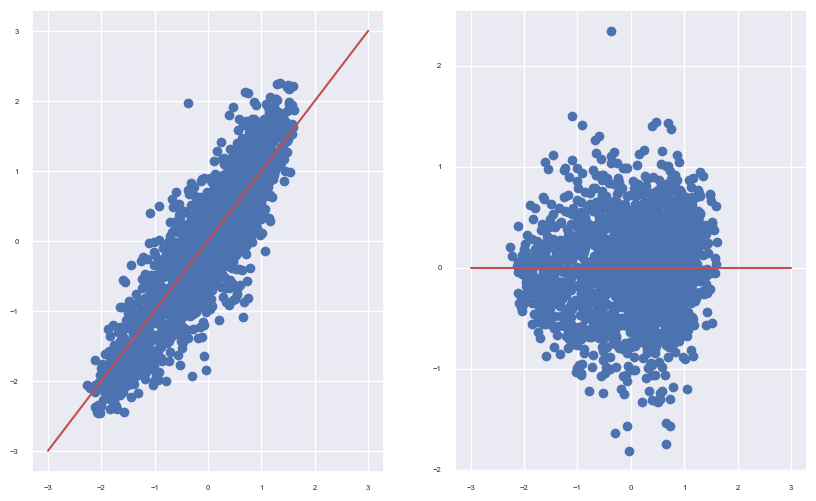

In [161]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yPercJumpPredRFR, yTestPercJump)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yPercJumpPredRFR, yTestPercJump - yPercJumpPredRFR.reshape(yTestPercJump.shape))
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

In [163]:
#look at the variable importance for our analysis
percJumpVarImpRFR = pd.DataFrame({'features':xTestPercJump.columns, 'importance':gsPercJumpRFR.best_estimator_.feature_importances_})

percJumpVarImpRFR["importance"] = percJumpVarImpRFR["importance"] / percJumpVarImpRFR["importance"].sum()

percJumpVarImpRFR

,features,importance
0,Age,0.036765
1,FG%,0.250760
2,FTA,0.108244
3,FT%,0.144262
4,TRB,0.324656
5,AST,0.032183
6,PF,0.043950
7,PTS,0.050000
8,Pos_PF,0.003189
9,Pos_PG,0.001709


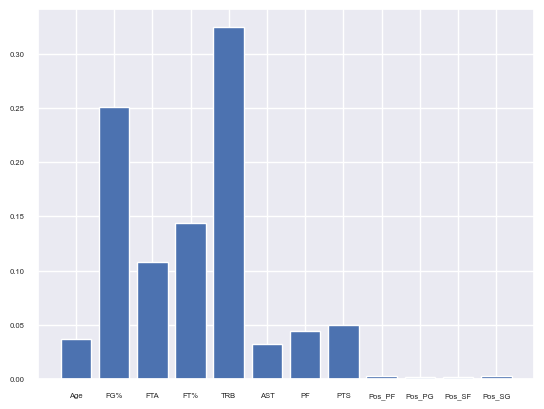

In [165]:
plt.bar(percJumpVarImpRFR['features'], percJumpVarImpRFR['importance'])
plt.show()

The most important variables for my model are TRB, FG%, FT%, and FTA. The position variables have very little impact on my model.

### XGBoost Regression
For xgboost, I grid searched 3 different values: n_estimators, max_depth, and learning_rate. Through cross-validation grid search found the best values to be n_estimators = 325, max_depth = 6, and learning_rate = 0.05. I originally had a greater spread of possible values to search from and used the results from those to zero in on the best values. XGBoost also performed extremely well and will be a contender for the best model

In [114]:
# Grid Search XGBoost model
xgbParams = {'n_estimators': [250, 275, 300, 325, 350],
             'max_depth': [3, 4, 5, 6, 7],
             'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
             'random_state': [1]}

gsPercJumpXGB = GridSearchCV(XGBRegressor(), xgbParams, cv = 5, scoring = ('r2', 'neg_mean_squared_error'), refit = 'neg_mean_squared_error', return_train_score = True, n_jobs = -1)
gsPercJumpXGB.fit(xTrainPercJump, np.ravel(yTrainPercJump))

# get cv scores
cvResultsXGBPercJump = pd.DataFrame(gsPercJumpXGB.cv_results_)[['params', 'mean_train_r2', 'mean_train_neg_mean_squared_error']]

print('Best r2: ' + str(cvResultsXGBPercJump.loc[(cvResultsXGBPercJump['params'] == gsPercJumpXGB.best_params_), 'mean_train_r2']))
print('Best RMSE: ' + str(np.sqrt(-1 * (cvResultsXGBPercJump.loc[(cvResultsXGBPercJump['params'] == gsPercJumpXGB.best_params_), 'mean_train_neg_mean_squared_error']))))
print('Best Params: ' + str(gsPercJumpXGB.best_params_))

Best r2: 68    0.926224
Name: mean_train_r2, dtype: float64
Best RMSE: 68    0.27146
Name: mean_train_neg_mean_squared_error, dtype: float64
Best Params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 325, 'random_state': 1}


In [116]:
# test against the test set
yPercJumpPredXGB = gsPercJumpXGB.predict(xTestPercJump)

testPercJumpR2xgb = r2_score(yTestPercJump, yPercJumpPredXGB)
testPercJumpRMSExgb = np.sqrt(mean_squared_error(yTestPercJump, yPercJumpPredXGB))

print('test RMSE: '+str(testPercJumpRMSExgb))
print('test r2: '+str(testPercJumpR2xgb))

test RMSE: 0.43585942854663917
test r2: 0.8107701192370663


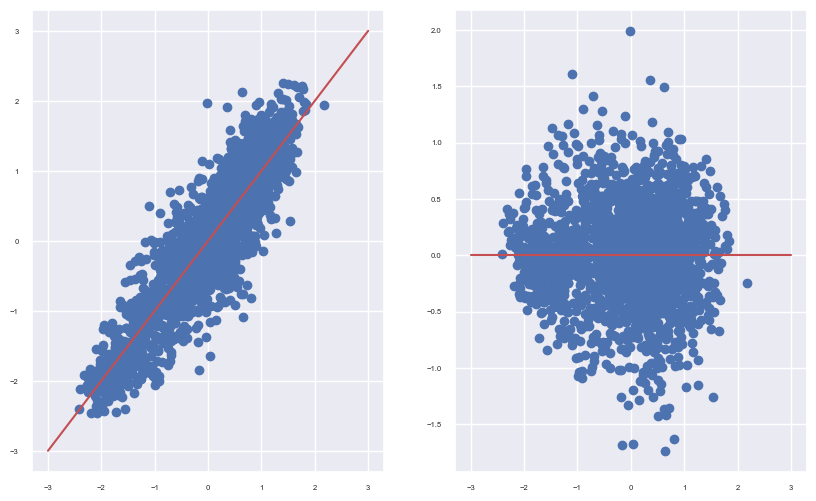

In [118]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yPercJumpPredXGB, yTestPercJump)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yPercJumpPredXGB, yTestPercJump - yPercJumpPredXGB.reshape(yTestPercJump.shape))
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

# Model Selection
Clearly we can see the best 3 performing models are SVM, MLP, and XGBoost. All of their RMSEs, R2, and residuals graphs are extremely similar. Since there is nothing special in the graphs to tell me otherwise, I will choose SVM because it has a slightly better RMSE and R2 after cross-validation.

**Choice: SVM**

I would consider this model robust in predicting the percentage of jumpshots a player takes. With an r2 north of .81, a low RMSE, and consitent residuals when graphing, I would trust this model to output the players who take the highest percentage of jump shots.

In [167]:
# compare Results on test set
comparisonDf = pd.DataFrame({'model': ['linear', 'pls', 'ridge', 'SVM', 'MLP', 'Random Forest', 'XGBoost'],
                             'test_rmse': [testPercJumpRMSElm, testPercJumpRMSEpls, testPercJumpRMSEridge, testPercJumpRMSEsvr,
                                           testPercJumpRMSEmlp, testPercJumpRMSErfr, testPercJumpRMSExgb],
                             'test_r2': [testPercJumpR2lm, testPercJumpR2pls, testPercJumpR2ridge, testPercJumpR2svr,
                                         testPercJumpR2mlp, testPercJumpR2rfr, testPercJumpR2xgb]})
comparisonDf

,model,test_rmse,test_r2
0,linear,0.456782,0.792167
1,pls,0.456784,0.792165
2,ridge,0.456726,0.792218
3,SVM,0.426742,0.818604
4,MLP,0.427752,0.817744
5,Random Forest,0.442292,0.805144
6,XGBoost,0.435859,0.810770


# Jumpshot Percentage

### Now the second part of the project, predicting jumpshot percentage

For predicting jumpshot percentage, I decided to add percentage of jumpshots to the model. This is because during my orignial estimations without using percentage of jumpshots, I was getting r2 values in the low .30, and adding it raised the r2 value to around .50. I added it because I knew that it would be an avaliable stat, since I am providing it with my predictions.

In [240]:
# separate into predictors and outcome
outcomeJumpPerc = pd.DataFrame(jumpshotPerc['jumpshotPercentage'])
predictorsJumpPerc = jumpshotPerc.drop('jumpshotPercentage', axis = 1)

In [241]:
predictorsJumpPerc.head()

,Age,FGA,FG%,FTA,FT%,TRB,AST,PF,PTS,percJumpshot,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,-0.335046,1.630040,0.319601,-0.022156,0.795720,-0.181355,0.913331,-1.985002,1.382453,0.568160,0,0,1,0
1,0.768414,1.778916,0.143809,0.623534,-0.173834,-0.100686,1.782472,-1.823158,1.721239,0.057159,0,1,0,0
2,0.351143,0.811981,-0.114956,0.623534,1.404723,-0.937717,0.515529,-1.669773,0.775377,0.453793,0,0,1,0
3,-1.109852,1.600173,1.070183,0.677294,0.146109,1.391362,0.877254,-1.252623,1.676510,0.092170,1,0,0,0
4,-1.109852,0.811981,0.473643,1.501009,0.659092,1.047278,0.226062,-0.775497,1.221613,-0.689955,0,0,1,0


In [244]:
outcomeJumpPerc.head()

,jumpshotPercentage
0,0.831030
1,-0.414500
2,0.614600
3,1.047818
4,-0.171181


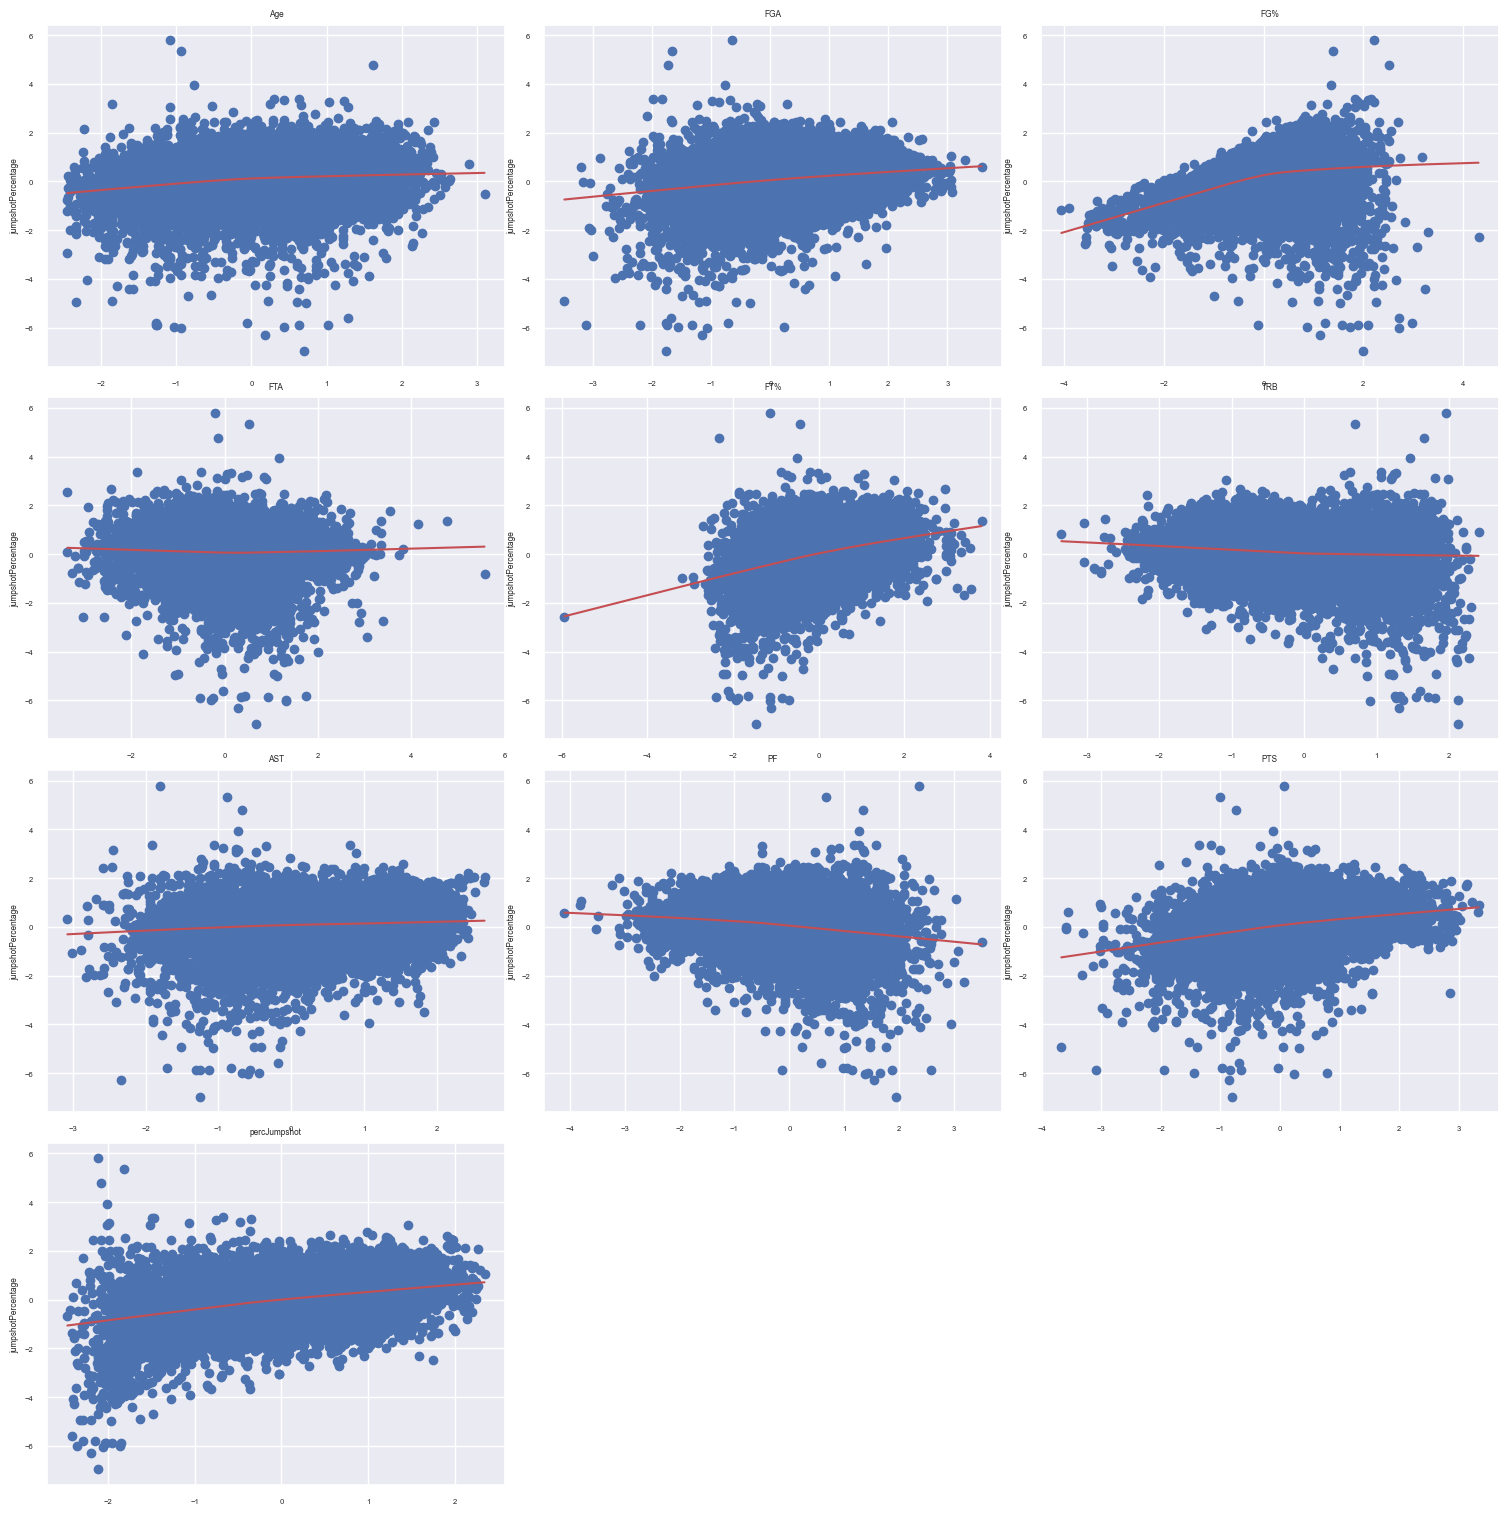

In [387]:
# look at lowess graphs for linearity
import statsmodels.api as sm

# predictorsContin contains the 9 continuous predictor columns
predictorsContinJumpPerc = predictorsJumpPerc[predictorsJumpPerc.columns[:-4]]

# Run local smoother lowess
lowess = sm.nonparametric.lowess

# Draw scatterplots
nrows = 4
ncols = 3

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
fig.tight_layout()

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Iterate through each column and plot
for i, col in enumerate(predictorsContinJumpPerc.columns):
    if i >= nrows * ncols:
        break  # Stop if we exceed the number of subplots

    X_graph = predictorsContinJumpPerc[col]
    z = lowess(np.squeeze(outcomeJumpPerc), np.squeeze(X_graph), frac=0.9)
    
    axs[i].scatter(X_graph, outcomeJumpPerc)
    axs[i].plot(z[:, 0], z[:, 1], 'r')
    axs[i].set_title(col)
    axs[i].set_ylabel(outcomeJumpPerc.columns[0])

# Hide any unused subplots
for j in range(i + 1, nrows * ncols):
    axs[j].axis('off')

plt.show()

In our lowess graphs, we can see very weak linear relationships with most of our predictors, with the only clear linear relationships being FG% and percentage of jumpshots. We also see a lot of heteroskedasicity. These two factors point to this outcome being much more difficult to predict.

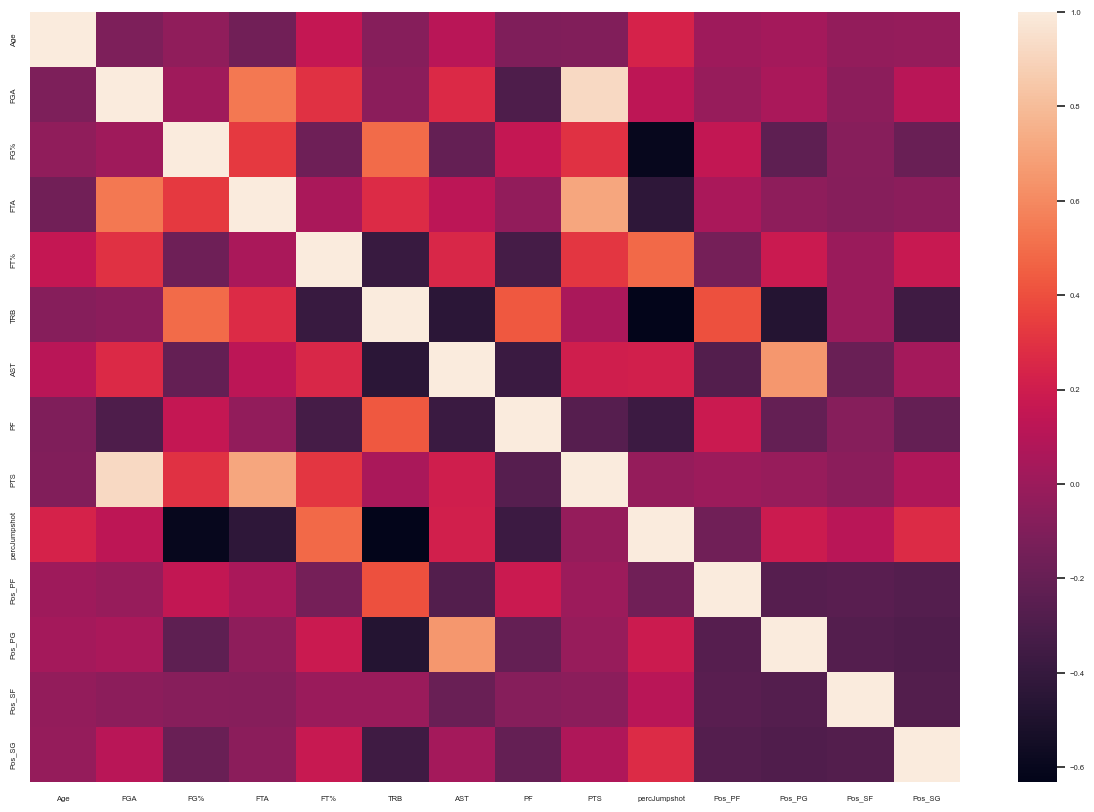

In [247]:
# derive correlation matrix 
corrDataJumpPerc = predictorsJumpPerc.corr()
corrDataJumpPerc.dropna()

# visualize correlation matrix

plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)
sns.heatmap(corrDataJumpPerc)
plt.show()

In [248]:
corrDataJumpPerc

,Age,FGA,FG%,FTA,FT%,TRB,AST,PF,PTS,percJumpshot,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Age,1.000000,-0.110520,-0.045232,-0.159867,0.153202,-0.078204,0.113736,-0.106259,-0.100375,0.231689,0.009164,0.032019,-0.026378,-0.022308
FGA,-0.110520,1.000000,0.013688,0.538951,0.293372,-0.061919,0.264540,-0.297834,0.923060,0.128981,-0.019105,0.051058,-0.051968,0.113044
FG%,-0.045232,0.013688,1.000000,0.329072,-0.170356,0.495954,-0.205144,0.153782,0.295714,-0.605588,0.150906,-0.233937,-0.076510,-0.185918
FTA,-0.159867,0.538951,0.329072,1.000000,0.051715,0.272997,0.124939,-0.035816,0.707887,-0.429511,0.053734,-0.051180,-0.078545,-0.061783
FT%,0.153202,0.293372,-0.170356,0.051715,1.000000,-0.385418,0.248635,-0.332549,0.317545,0.488092,-0.146078,0.180168,-0.004493,0.170920
TRB,-0.078204,-0.061919,0.495954,0.272997,-0.385418,1.000000,-0.441101,0.427717,0.051901,-0.631905,0.404700,-0.473415,-0.003156,-0.358929
AST,0.113736,0.264540,-0.205144,0.124939,0.248635,-0.441101,1.000000,-0.380410,0.206338,0.215452,-0.276668,0.653921,-0.186039,0.035948
PF,-0.106259,-0.297834,0.153782,-0.035816,-0.332549,0.427717,-0.380410,1.000000,-0.267228,-0.373205,0.180681,-0.209978,-0.078373,-0.206396
PTS,-0.100375,0.923060,0.295714,0.707887,0.317545,0.051901,0.206338,-0.267228,1.000000,-0.020104,0.005419,-0.013939,-0.058725,0.069627
percJumpshot,0.231689,0.128981,-0.605588,-0.429511,0.488092,-0.631905,0.215452,-0.373205,-0.020104,1.000000,-0.163856,0.186084,0.108757,0.268376


In [249]:
predictorsJumpPercReduced = eliminateCorr(predictorsJumpPerc, 0.75)

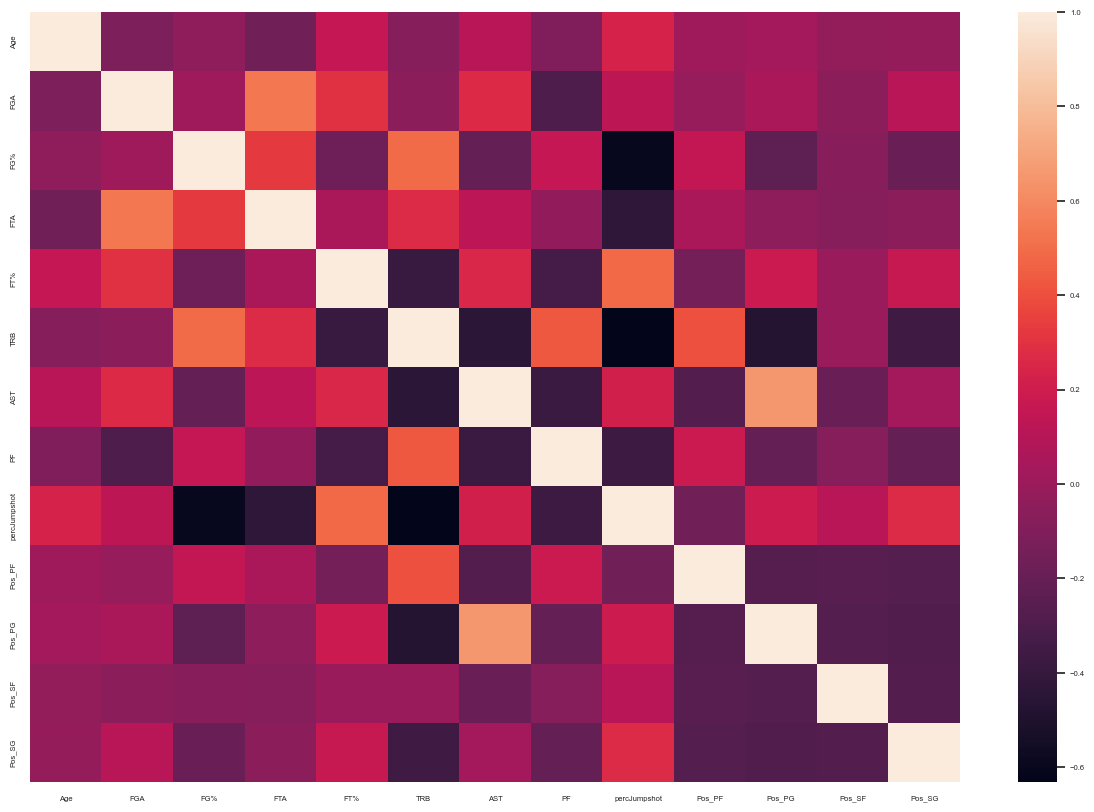

In [250]:
# derive correlation matrix 
corrDataJumpPercReduced = predictorsJumpPercReduced.corr()
corrDataJumpPercReduced.dropna()

# visualize correlation matrix

plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)
sns.heatmap(corrDataJumpPercReduced)
plt.show()

### Removing high correlation
An interesting change when removing highly correlated predictors compared to the last model is that it removed PTS instead of FGA. This is because the datasets are not completely the same, as I added percentage of jumpshots to the mix and took away around 1000 observations due to missing values.

In [251]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets

xTrainJumpPerc, xTestJumpPerc, yTrainJumpPerc, yTestJumpPerc = train_test_split(predictorsJumpPercReduced, outcomeJumpPerc, test_size=0.2, random_state = 1)

# Model Selection and Evaluation

### Linear Regression
Immediately, we see in our cross-validation that predicting jumpshot percentage will be more difficult than percentage of jumpshots. We see a training r2 of .52 and testing r2 of .49, significantly lower than our percentage of jumpshots predictions.

In [252]:
# instantiate Linear Regression
lmJumpPerc = LinearRegression()

# calculate cv scores
cvScoresJumpPercLM = cross_validate(lmJumpPerc, xTrainJumpPerc, yTrainJumpPerc, cv = cvParam, scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True)
rmseJumpPercLM = np.sqrt(-1 * np.mean(cvScoresJumpPercLM['train_neg_mean_squared_error']))

print('train RMSE: ' + str(rmseJumpPercLM))
print('train r2: ' + str(np.mean(cvScoresJumpPercLM['train_r2'])))

train RMSE: 0.6936480360726155
train r2: 0.5237876147571728


In [253]:
# test against the test set
lmJumpPerc.fit(xTrainJumpPerc, yTrainJumpPerc)
yJumpPercPredLm = lmJumpPerc.predict(xTestJumpPerc)

testJumpPercR2lm = r2_score(yTestJumpPerc, yJumpPercPredLm)
testJumpPercRMSElm = np.sqrt(mean_squared_error(yTestJumpPerc, yJumpPercPredLm))

print('test RMSE: '+str(testJumpPercRMSElm))
print('test r2: '+str(testJumpPercR2lm))

test RMSE: 0.7021752068197735
test r2: 0.4854758157785294


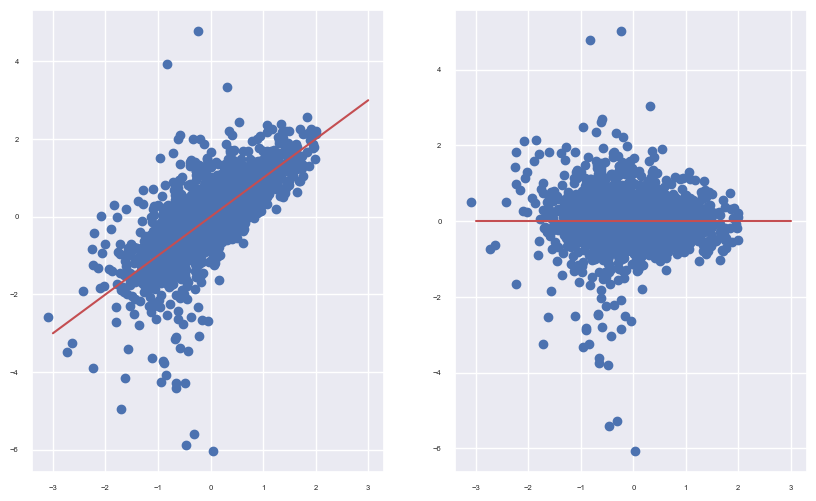

In [254]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yJumpPercPredLm, yTestJumpPerc)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yJumpPercPredLm, yTestJumpPerc - yJumpPercPredLm)
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

Investigating our prediction vs actual and residual graphs, we can see where our model goes wrong. There are a lot of large negitive residuals in our model, meaning we are underpredicting a lot of our dataset.

### PLS Regression
Using PLS to try to improve the efficiency of our model, we see we can get about the same model performance with only 4 components. So, if no model shows improvement over a linear regression, PLS will be the best for efficiency.

In [255]:
# instantiate PLS Regression

rmseJumpPercPLS = []
r2JumpPercPLS = []

for i in range(1, 13):
    pls = PLSRegression(n_components = i)
    score = cross_validate(pls, xTrainJumpPerc, yTrainJumpPerc, cv = cvParam, scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True)
    rmseJumpPercPLS.append(np.sqrt(-np.mean(score['train_neg_mean_squared_error'])))
    r2JumpPercPLS.append(np.mean(score['train_r2']))

# print minimum RMSE for PLS
print('Minimum RMSE for PLS: ' + str(np.min(rmseJumpPercPLS)))

# number of units used for min RMSE
print('# of components for RMSE PLS: ' + str(np.argmin(rmseJumpPercPLS)))

print('==========================')

# maximum r2 for PLS
print('Maximum r2 for PLS: ' + str(np.max(r2JumpPercPLS)))

# number of units used for max r2
print('# of components for R2 PLS: ' + str(np.argmax(r2JumpPercPLS)))

Minimum RMSE for PLS: 0.6936480380591652
# of components for RMSE PLS: 11
Maximum r2 for PLS: 0.5237876120314241
# of components for R2 PLS: 11


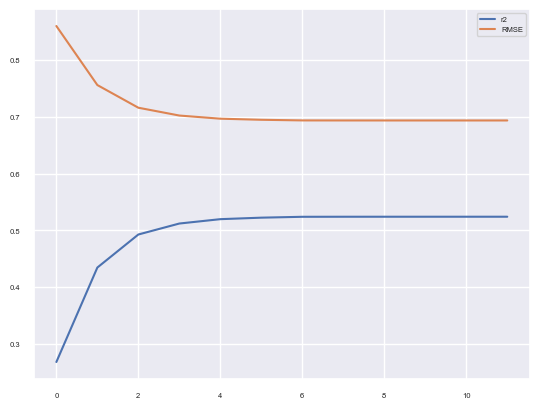

In [256]:
plt.plot(r2JumpPercPLS, label = 'r2')
plt.plot(rmseJumpPercPLS, label = 'RMSE')
plt.legend()
plt.show()

In [467]:
# get predictions
plsJumpPerc = PLSRegression(n_components = 4)
plsJumpPerc.fit(xTrainJumpPerc, yTrainJumpPerc)
yJumpPercPredPLS = plsJumpPerc.predict(xTestJumpPerc)

testJumpPercR2pls = r2_score(yTestJumpPerc, yJumpPercPredPLS)
testJumpPercRMSEpls = np.sqrt(mean_squared_error(yTestJumpPerc, yJumpPercPredPLS))

print('test RMSE: '+str(testJumpPercRMSEpls))
print('test r2: '+str(testJumpPercR2pls))

test RMSE: 0.7106876889119369
test r2: 0.4729250263775313


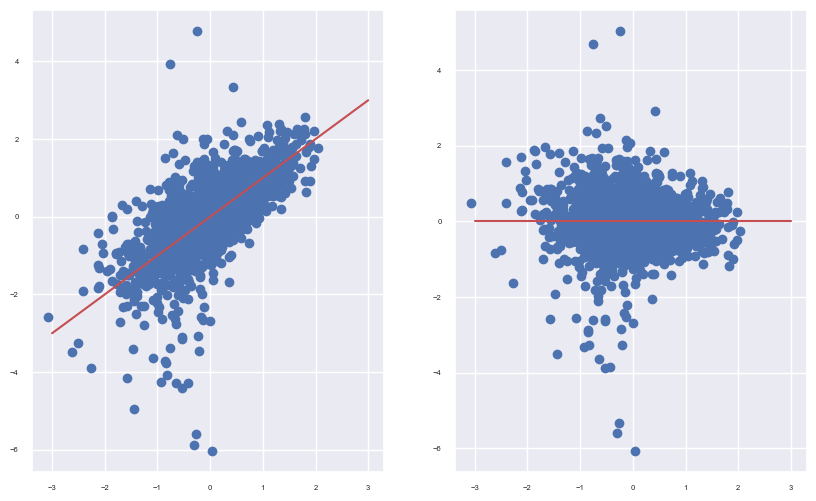

In [469]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yJumpPercPredPLS, yTestJumpPerc)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yJumpPercPredPLS, yTestJumpPerc - yJumpPercPredPLS)
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

### Ridge Regression
I again choose ridge because I have few predictors and do not want to drop any of them. Grid searching our alpha returns a higher alpha than before, meaning there is a need to correct outliers in the data. We do not see much of a difference between the linear and the ridge though.

In [272]:
# Grid Search Ridge Regression
ridgeParam = {'alpha': np.linspace(0, 50, 51)}

gsRidgeJumpPerc = GridSearchCV(Ridge(), ridgeParam, cv = cvParam, scoring = ('r2', 'neg_mean_squared_error'), refit = 'neg_mean_squared_error', return_train_score = True, n_jobs = -1)
gsRidgeJumpPerc.fit(xTrainJumpPerc, yTrainJumpPerc)
cvResultsRidgeJumpPerc = pd.DataFrame(gsRidgeJumpPerc.cv_results_)[['params', 'mean_train_r2', 'mean_train_neg_mean_squared_error']]

print('Best Train r2: ' + str(cvResultsRidgeJumpPerc['mean_train_r2'].max()))
print('Best Train RMSE: ' + str(np.sqrt(-1 * (cvResultsRidgeJumpPerc['mean_train_neg_mean_squared_error'].max()))))
print('Best Params: ' + str(gsRidgeJumpPerc.best_params_))

Best Train r2: 0.5237876147571728
Best Train RMSE: 0.6936480360726155
Best Params: {'alpha': 9.0}


In [274]:
# test against the test set
yJumpPercPredRidge = gsRidgeJumpPerc.predict(xTestJumpPerc)

testJumpPercR2ridge = r2_score(yTestJumpPerc, yJumpPercPredRidge)
testJumpPercRMSEridge = np.sqrt(mean_squared_error(yTestJumpPerc, yJumpPercPredRidge))

print('test RMSE: '+str(testJumpPercRMSEridge))
print('test r2: '+str(testJumpPercR2ridge))

test RMSE: 0.7022455404146211
test r2: 0.48537273567097605


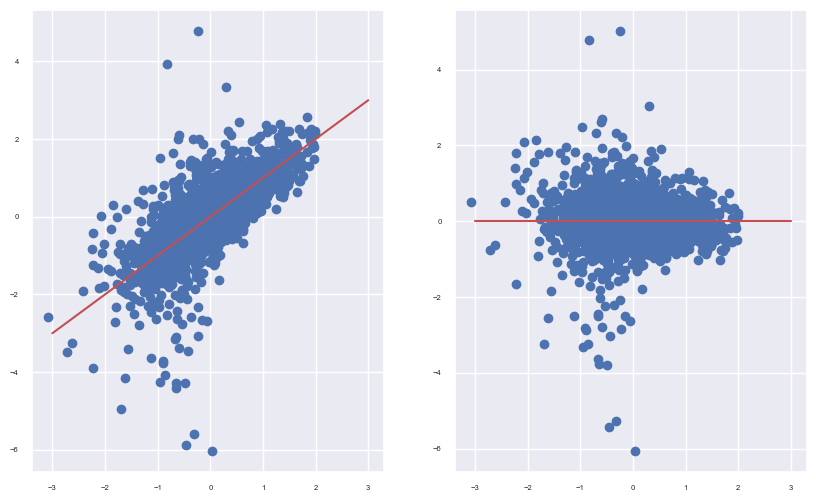

In [276]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yJumpPercPredRidge, yTestJumpPerc)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yJumpPercPredRidge, yTestJumpPerc - yJumpPercPredRidge)
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

### SVM Regression
I again used grid search on the same parameters, and the best model again was the same values. SVM performed better than the linear models and has a chance to be our best model.

In [278]:
# Grid Search SVM model
svmParams = {'kernel': ['poly','rbf'],
             'epsilon': [0.01, 0.05, 0.1, 0.5, 1],
             'C': [0.1, 1, 5, 10, 15, 25]}

gsJumpPercSVM = GridSearchCV(SVR(), svmParams, cv = 5, scoring = ('r2', 'neg_mean_squared_error'), refit = 'neg_mean_squared_error', return_train_score = True, n_jobs = -1)
gsJumpPercSVM.fit(xTrainJumpPerc, np.ravel(yTrainJumpPerc))

# get cv scores
cvResultsSVMJumpPerc = pd.DataFrame(gsJumpPercSVM.cv_results_)[['params', 'mean_train_r2', 'mean_train_neg_mean_squared_error']]

print('Best r2: ' + str(cvResultsSVMJumpPerc.loc[(cvResultsSVMJumpPerc['params'] == gsJumpPercSVM.best_params_), 'mean_train_r2']))
print('Best RMSE: ' + str(np.sqrt(-1 * (cvResultsSVMJumpPerc.loc[(cvResultsSVMJumpPerc['params'] == gsJumpPercSVM.best_params_), 'mean_train_neg_mean_squared_error']))))
print('Best Params: ' + str(gsJumpPercSVM.best_params_))

Best r2: 15    0.634751
Name: mean_train_r2, dtype: float64
Best RMSE: 15    0.607378
Name: mean_train_neg_mean_squared_error, dtype: float64
Best Params: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}


In [279]:
# test against the test set
yJumpPercPredSVR = gsJumpPercSVM.predict(xTestJumpPerc)

testJumpPercR2svr = r2_score(yTestJumpPerc, yJumpPercPredSVR)
testJumpPercRMSEsvr = np.sqrt(mean_squared_error(yTestJumpPerc, yJumpPercPredSVR))

print('test RMSE: '+str(testJumpPercRMSEsvr))
print('test r2: '+str(testJumpPercR2svr))

test RMSE: 0.6752435007903586
test r2: 0.5241877305986271


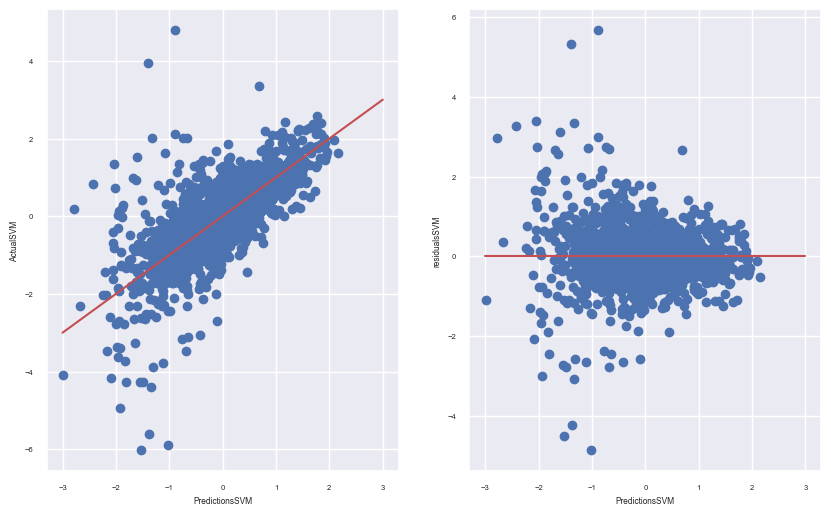

In [280]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yJumpPercPredSVR, yTestJumpPerc)
ax1.plot(yRange, yRange, c = 'r')
ax1.set_xlabel('PredictionsSVM')
ax1.set_ylabel('ActualSVM')

ax2.scatter(yJumpPercPredSVR, (yTestJumpPerc - yJumpPercPredSVR.reshape(yTestJumpPerc.shape)))
ax2.plot(yRange, (yRange - yRange), c = 'r')
ax2.set_xlabel('PredictionsSVM')
ax2.set_ylabel('residualsSVM')

plt.show()

We can see that compared to the linear models, SVM has lower residuals, though they are more evenly distributed between positive and negative. 

### MLP Regressor (Neural Network)
With the same parameters in our grid search, we get different optimal values, with an optimal hidden_layer_size of (100, 50, ) and an optimal alpha of 1. This regression performed better on our test set than the SVM model.

In [284]:
# Grid Search MLPRegressor
mlpParams = {'hidden_layer_sizes': [(10, ), (50, ), (100, ), (50, 20, ), (100, 50, ), (50, 30, 10, ), (100, 50, 20, ), (50, 30, 20, 10, )],
            'alpha': [0.00, 0.0001, 0.001, 0.01, 0.1, 1],
            'max_iter': [1000]}

gsJumpPercMLP = GridSearchCV(MLPRegressor(), mlpParams, cv = 5, scoring = ('r2', 'neg_mean_squared_error'), refit = 'neg_mean_squared_error', return_train_score = True, n_jobs = -1)
gsJumpPercMLP.fit(xTrainJumpPerc, np.ravel(yTrainJumpPerc))

# get cv scores
cvResultsMLPJumpPerc = pd.DataFrame(gsJumpPercMLP.cv_results_)[['params', 'mean_train_r2', 'mean_train_neg_mean_squared_error']]

print('Best r2: ' + str(cvResultsMLPJumpPerc.loc[(cvResultsMLPJumpPerc['params'] == gsJumpPercMLP.best_params_), 'mean_train_r2']))
print('Best RMSE: ' + str(np.sqrt(-1 * (cvResultsMLPJumpPerc.loc[(cvResultsMLPJumpPerc['params'] == gsJumpPercMLP.best_params_), 'mean_train_neg_mean_squared_error']))))
print('Best Params: ' + str(gsJumpPercMLP.best_params_))

Best r2: 44    0.611751
Name: mean_train_r2, dtype: float64
Best RMSE: 44    0.626211
Name: mean_train_neg_mean_squared_error, dtype: float64
Best Params: {'alpha': 1, 'hidden_layer_sizes': (100, 50), 'max_iter': 1000}


In [285]:
# test against the test set
yJumpPercPredMLP = gsJumpPercMLP.predict(xTestJumpPerc)

testJumpPercR2mlp = r2_score(yTestJumpPerc, yJumpPercPredMLP)
testJumpPercRMSEmlp = np.sqrt(mean_squared_error(yTestJumpPerc, yJumpPercPredMLP))

print('test RMSE: '+str(testJumpPercRMSEmlp))
print('test r2: '+str(testJumpPercR2mlp))

test RMSE: 0.6694850074440005
test r2: 0.5322686038041617


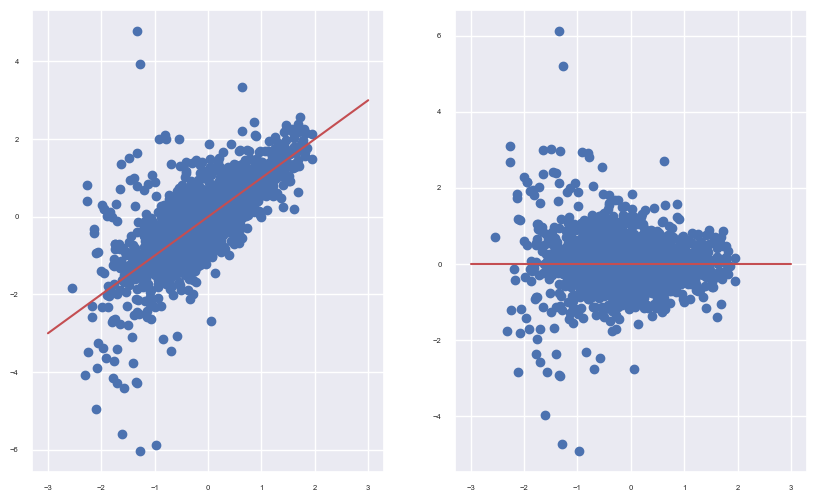

In [286]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yJumpPercPredMLP, yTestJumpPerc)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yJumpPercPredMLP, yTestJumpPerc - yJumpPercPredMLP.reshape(yTestJumpPerc.shape))
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

An important thing to notice in these graphs is that they are tightening at the top, with lower residuals for our top predictions. This is ultimately what we care about the most, since we are the most interested in the best shooters in the league. 

### Random Forest Regressor
I again grid searched the same parameters as before but got different best parameters again. This regression also shows signs of overfitting the training set (as all of our tree models do), but it is also our model with the best r2 and RMSE on the test set.

In [290]:
# Grid Search Random Forest Regressor
rfrParams = {'n_estimators': [500, 750, 1000],
             'max_depth': [None, 20, 30, 50],
             'max_features': ['sqrt', 0.5],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [6, 7, 8, 9, 10],
             'random_state': [1],
             'criterion': ['squared_error']}

gsJumpPercRFR = GridSearchCV(RandomForestRegressor(), rfrParams, cv = 5, scoring = ('r2', 'neg_mean_squared_error'), refit = 'neg_mean_squared_error', return_train_score = True, n_jobs = -1)
gsJumpPercRFR.fit(xTrainJumpPerc, np.ravel(yTrainJumpPerc))

# get cv scores
cvResultsRFRJumpPerc = pd.DataFrame(gsJumpPercRFR.cv_results_)[['params', 'mean_train_r2', 'mean_train_neg_mean_squared_error']]

print('Best r2: ' + str(cvResultsRFRJumpPerc.loc[(cvResultsRFRJumpPerc['params'] == gsJumpPercRFR.best_params_), 'mean_train_r2']))
print('Best RMSE: ' + str(np.sqrt(-1 * (cvResultsRFRJumpPerc.loc[(cvResultsRFRJumpPerc['params'] == gsJumpPercRFR.best_params_), 'mean_train_neg_mean_squared_error']))))
print('Best Params: ' + str(gsJumpPercRFR.best_params_))

Best r2: 226    0.903361
Name: mean_train_r2, dtype: float64
Best RMSE: 226    0.312408
Name: mean_train_neg_mean_squared_error, dtype: float64
Best Params: {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 750, 'random_state': 1}


In [291]:
# test against the test set
yJumpPercPredRFR = gsJumpPercRFR.predict(xTestJumpPerc)

testJumpPercR2rfr = r2_score(yTestJumpPerc, yJumpPercPredRFR)
testJumpPercRMSErfr = np.sqrt(mean_squared_error(yTestJumpPerc, yJumpPercPredRFR))

print('test RMSE: '+str(testJumpPercRMSErfr))
print('test r2: '+str(testJumpPercR2rfr))

test RMSE: 0.6704278821431656
test r2: 0.5309502093783744


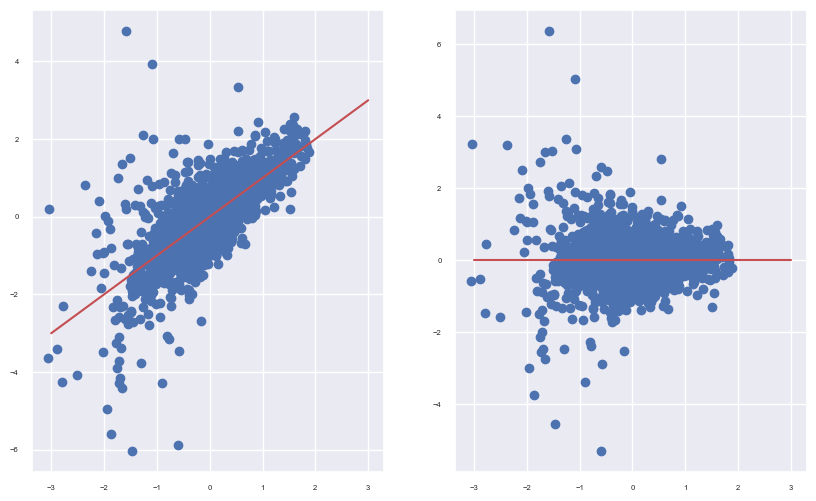

In [292]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yJumpPercPredRFR, yTestJumpPerc)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yJumpPercPredRFR, yTestJumpPerc - yJumpPercPredRFR.reshape(yTestJumpPerc.shape))
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

In [293]:
#look at the variable importance for our analysis
jumpPercVarImpRFR = pd.DataFrame({'features':xTestJumpPerc.columns, 'importance':gsJumpPercRFR.best_estimator_.feature_importances_})

jumpPercVarImpRFR["importance"] = jumpPercVarImpRFR["importance"] / jumpPercVarImpRFR["importance"].sum()

jumpPercVarImpRFR

,features,importance
0,Age,0.050306
1,FGA,0.060466
2,FG%,0.293901
3,FTA,0.049150
4,FT%,0.142777
5,TRB,0.054915
6,AST,0.043401
7,PF,0.047396
8,percJumpshot,0.244591
9,Pos_PF,0.003622


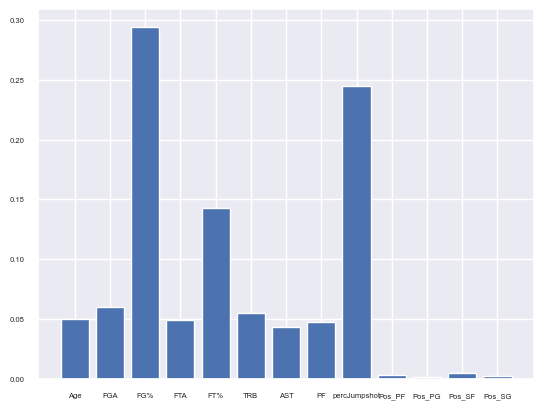

In [294]:
plt.bar(jumpPercVarImpRFR['features'], jumpPercVarImpRFR['importance'])
plt.show()

We can see the benefit here of adding percentage of jumpshots to our models. Our most important predictors for jumpshot percentage are FG%, percentage of jumpshots, and FT%. We again see little value in the positions being added to the models.

### XGBRegressor
This is again a very similar model with the exact same tuning parameters as for percentage of jumpshots. In the cross-validations we see that XGBoost does not perform as well as the other more complex models.

In [300]:
# Grid Search XGBoost model
xgbParams = {'n_estimators': [250, 275, 300, 325, 350],
             'max_depth': [3, 4, 5, 6, 7],
             'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
             'random_state': [1]}

gsJumpPercXGB = GridSearchCV(XGBRegressor(), xgbParams, cv = 5, scoring = ('r2', 'neg_mean_squared_error'), refit = 'neg_mean_squared_error', return_train_score = True, n_jobs = -1)
gsJumpPercXGB.fit(xTrainJumpPerc, np.ravel(yTrainJumpPerc))

# get cv scores
cvResultsXGBJumpPerc = pd.DataFrame(gsJumpPercXGB.cv_results_)[['params', 'mean_train_r2', 'mean_train_neg_mean_squared_error']]

print('Best r2: ' + str(cvResultsXGBJumpPerc.loc[(cvResultsXGBJumpPerc['params'] == gsJumpPercXGB.best_params_), 'mean_train_r2']))
print('Best RMSE: ' + str(np.sqrt(-1 * (cvResultsXGBJumpPerc.loc[(cvResultsXGBJumpPerc['params'] == gsJumpPercXGB.best_params_), 'mean_train_neg_mean_squared_error']))))
print('Best Params: ' + str(gsJumpPercXGB.best_params_))

Best r2: 51    0.68566
Name: mean_train_r2, dtype: float64
Best RMSE: 51    0.563463
Name: mean_train_neg_mean_squared_error, dtype: float64
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'random_state': 1}


In [301]:
# test against the test set
yJumpPercPredXGB = gsJumpPercXGB.predict(xTestJumpPerc)

testJumpPercR2xgb = r2_score(yTestJumpPerc, yJumpPercPredXGB)
testJumpPercRMSExgb = np.sqrt(mean_squared_error(yTestJumpPerc, yJumpPercPredXGB))

print('test RMSE: '+str(testJumpPercRMSExgb))
print('test r2: '+str(testJumpPercR2xgb))

test RMSE: 0.6788976412652891
test r2: 0.5190239951632314


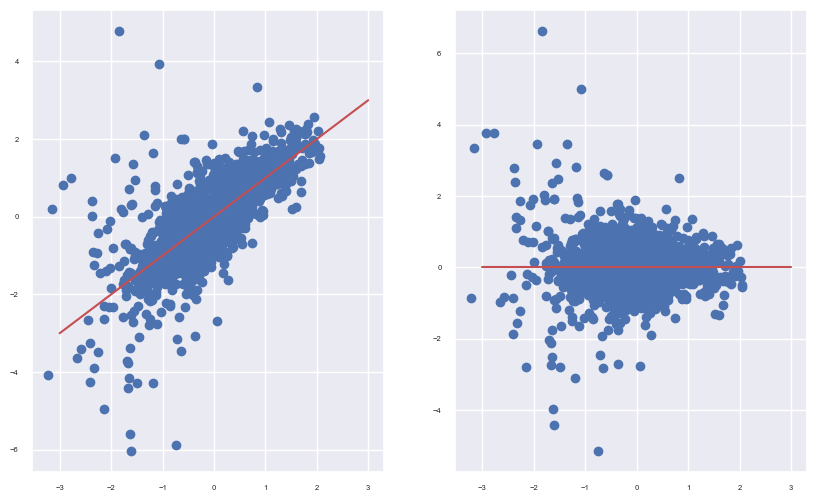

In [302]:
# graph predictions vs test set
yRange = np.linspace(-3, 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.scatter(yJumpPercPredXGB, yTestJumpPerc)
ax1.plot(yRange, yRange, c = 'r')

ax2.scatter(yJumpPercPredXGB, yTestJumpPerc - yJumpPercPredXGB.reshape(yTestJumpPerc.shape))
ax2.plot(yRange, (yRange - yRange), c = 'r')

plt.show()

The graphs for XGBoost are much more erratic than the other complex models, with a lot of large residuals both positive and negative.

# Model Selection
Model selection for my jumpshot percentage model comes down to our 3 best performing models: SVM, MLP, and Random Forest. With the models being so close, I think it is imperative to reconsider what we are looking for in our model. More than anything, we want to know who the *best* shooters are. So I think my model selection should take into account the residuals on the higher values of our model predictions (the +2 and +3 values). Ideally, these would be clumped on our residuals graph to show accurate estimation of the best shooters. Of our 3 best models, I think MLP regressor does the best job at predicting the best shooters in the league, so that will ultimately be my choice for this outcome.

**Best Model: MLP Regressor**

I would consider this model to be pretty good for predicting who the good shooters are. As the estimations return back to league average and below league average I would put less weight on the output of this model, and if there is a known good shooter predicted at league or below league average, I would likely side closer to the public opinion than the output of the model.

In [471]:
# compare Results on test set
comparisonDf = pd.DataFrame({'model': ['linear', 'pls', 'ridge', 'SVM', 'MLP', 'Random Forest', 'XGBoost'],
                             'test_rmse': [testJumpPercRMSElm, testJumpPercRMSEpls, testJumpPercRMSEridge, testJumpPercRMSEsvr,
                                           testJumpPercRMSEmlp, testJumpPercRMSErfr, testJumpPercRMSExgb],
                             'test_r2': [testJumpPercR2lm, testJumpPercR2pls, testJumpPercR2ridge, testJumpPercR2svr,
                                         testJumpPercR2mlp, testJumpPercR2rfr, testJumpPercR2xgb]})
comparisonDf

,model,test_rmse,test_r2
0,linear,0.702175,0.485476
1,pls,0.710688,0.472925
2,ridge,0.702246,0.485373
3,SVM,0.675244,0.524188
4,MLP,0.669485,0.532269
5,Random Forest,0.670428,0.530950
6,XGBoost,0.678898,0.519024


# Predicting Percentage of FGA that are Jumpshots and Jumpshot Percentage for pre-1980 NBA

Now it is time to apply my 2 best models (SVM for percentage of jumpshots and MLP for jumpshot percentage) to the analysis of the pre-three point line NBA. To do this, I collected the Per 36 minute box score data for the seasons 1979 - 1952 and ran it through the same pre-processing that I did with my original dataset, including centering and scaling the variables with respect to their years and getting dummies for position.

In [408]:
def data_processing_pre_1980(year):
    # read in data
    df = pd.read_csv(f"Per_36 Box Score Data/NBA Per_36 Box Score Data {year} - Sheet1.csv")
    df = df[df['MP'] > 375]
    df = df[(df['Team'] != '2TM') | (df['Team'] != '3TM') | (df['Team'] != '4TM') | (df['Team'] != '5TM')]

    # delete unneeded columns
    neededCols = ['Player', 'Age', 'Pos', 'FGA', 'FG%', 'FTA', 'FT%', 'TRB', 'AST', 'PF', 'PTS']
    df = df.loc[:, neededCols]

    # get dummies for position
    dummies = pd.get_dummies(df.iloc[:, 1:], drop_first = True, dtype = 'int')
    df[['Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG']] = dummies[['Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG']]

    # rename Pos into Year
    df['Pos'] = year
    df = df.rename(columns = {'Pos': 'Year'})

    # center and scale
    continCols = ['Age', 'FGA', 'FG%', 'FTA', 'FT%', 'TRB', 'AST', 'PF', 'PTS']
    df.loc[:, continCols] = df.loc[:, continCols].apply(lambda x: boxcox(x + 0.01)[0])
    df.loc[:, continCols] = df.loc[:, continCols].apply(lambda x: scale(x))
    
    return df

In [436]:
# get pre-1980 data
df1979 = data_processing_pre_1980(1979)
df1978 = data_processing_pre_1980(1978)
df1977 = data_processing_pre_1980(1977)
df1976 = data_processing_pre_1980(1976)
df1975 = data_processing_pre_1980(1975)
df1974 = data_processing_pre_1980(1974)
df1973 = data_processing_pre_1980(1973)
df1972 = data_processing_pre_1980(1972)
df1971 = data_processing_pre_1980(1971)
df1970 = data_processing_pre_1980(1970)
df1969 = data_processing_pre_1980(1969)
df1968 = data_processing_pre_1980(1968)
df1967 = data_processing_pre_1980(1967)
df1966 = data_processing_pre_1980(1966)
df1965 = data_processing_pre_1980(1965)
df1964 = data_processing_pre_1980(1964)
df1963 = data_processing_pre_1980(1963)
df1962 = data_processing_pre_1980(1962)
df1961 = data_processing_pre_1980(1961)
df1960 = data_processing_pre_1980(1960)
df1959 = data_processing_pre_1980(1959)
df1958 = data_processing_pre_1980(1958)
df1957 = data_processing_pre_1980(1957)
df1956 = data_processing_pre_1980(1956)
df1955 = data_processing_pre_1980(1955)
df1954 = data_processing_pre_1980(1954)
df1953 = data_processing_pre_1980(1953)
df1952 = data_processing_pre_1980(1952)

In [437]:
# concatinate the data
dfPre1980 = pd.concat([df1979, df1978, df1977, df1976, df1975, df1974, df1973, df1972, df1971, df1970,
                       df1969, df1968, df1967, df1966, df1965, df1964, df1963, df1962, df1961, df1960,
                       df1959, df1958, df1957, df1956, df1955, df1954, df1953, df1952])
dfPre1980.head()

,Player,Age,Year,FGA,FG%,FTA,FT%,TRB,AST,PF,PTS,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,Moses Malone,-1.038516,1979,0.238220,1.553870,2.199419,-0.118900,2.084073,-1.448441,-1.517126,1.304103,0,0,0,0
1,Artis Gilmore,0.970530,1979,0.324843,2.490042,1.437840,-0.118900,1.388213,-0.184280,-0.688024,1.264455,0,0,0,0
2,M.L. Carr,0.712095,1979,-0.138351,0.898987,0.688922,-0.074674,0.186424,-0.252542,-0.688024,0.309656,0,0,1,0
3,Kareem Abdul-Jabbar,1.423459,1979,0.612881,2.545437,0.944233,-0.151850,1.428653,0.804362,-1.261392,1.323874,0,0,0,0
4,Norm Nixon,-1.038516,1979,-0.022268,1.605675,-1.221087,0.291255,-1.447928,1.891630,-0.907285,0.156114,0,1,0,0


In [440]:
dfPre1980.shape

(4109, 15)

In [442]:
dfPre1980.isna().sum()

Player    0
Age       0
Year      0
FGA       0
FG%       0
FTA       0
FT%       0
TRB       0
AST       0
PF        0
PTS       0
Pos_PF    0
Pos_PG    0
Pos_SF    0
Pos_SG    0
dtype: int64

In [444]:
# use best model to predict % of FGA that are Jumpshots
impColsPercJump = ['Age', 'FG%', 'FTA', 'FT%', 'TRB', 'AST', 'PF', 'PTS', 'Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG']
predictorsPercJump1980 = dfPre1980.loc[:, impColsPercJump]
predictionsPercJump = gsPercJumpSVM.predict(predictorsPercJump1980)
dfPre1980['percJumpshot'] = predictionsPercJump
dfPre1980.sort_values('percJumpshot', ascending = False).head()

,Player,Age,Year,FGA,FG%,FTA,FT%,TRB,AST,PF,PTS,Pos_PF,Pos_PG,Pos_SF,Pos_SG,percJumpshot
86,Jon McGlocklin,1.008584,1974,0.035651,0.467221,-1.888809,2.033821,-1.504347,0.695719,-1.491919,-0.143856,0,0,0,1,1.787239
205,Charles Johnson,0.748477,1978,1.061712,-1.170340,-2.892654,-0.654862,-0.659056,0.195427,0.045536,-0.143688,0,0,0,1,1.782404
67,Vince Boryla,0.008732,1954,0.584354,-0.718996,-1.886144,2.490329,-1.432204,-1.212290,-0.898270,-0.432720,0,0,1,0,1.720700
104,Jon McGlocklin,1.293775,1975,-0.017977,1.196801,-2.102731,1.567485,-1.789602,1.039469,-1.162602,-0.050378,0,0,0,1,1.699796
89,Jon McGlocklin,0.775860,1973,-0.280111,1.182509,-2.399365,1.517683,-1.505120,0.697459,-1.584752,-0.198992,0,0,0,1,1.683688


Our most jumpshot-happy players of the pre-1980 Era of the NBA according to my SVM model are Jon McGlocklin, Charles Johnson, and Vince Boryla, with McGlocklin having 3 seasons in the top 5 of highest percentage of FGA being jumpshots.

In [449]:
# use best model to predict Jumpshot Percentage
impColsJumpPerc = ['Age', 'FGA', 'FG%', 'FTA', 'FT%', 'TRB', 'AST', 'PF', 'percJumpshot', 'Pos_PF', 'Pos_PG', 'Pos_SF', 'Pos_SG']
predictorsJumpPerc1980 = dfPre1980.loc[:, impColsJumpPerc]
predictionsJumpPerc = gsJumpPercMLP.predict(predictorsJumpPerc1980)
dfPre1980['jumpshotPercentage'] = predictionsJumpPerc
dfPre1980.sort_values('jumpshotPercentage', ascending = False).head()

,Player,Age,Year,FGA,FG%,FTA,FT%,TRB,AST,PF,PTS,Pos_PF,Pos_PG,Pos_SF,Pos_SG,percJumpshot,jumpshotPercentage
30,Jon McGlocklin,0.310718,1971,-0.221613,2.236181,-2.009240,1.870634,-1.638345,0.421693,-1.594801,0.135116,0,0,0,1,1.232009,2.482772
16,Bill Sharman,0.355715,1954,1.013170,2.264506,0.648956,2.137904,-1.078698,0.474578,-0.780834,1.674149,0,0,0,1,0.502696,2.205318
41,Matt Guokas,0.535812,1973,-2.115167,2.375101,-2.780312,0.871426,-1.410123,1.020001,-1.350554,-1.667537,0,0,0,1,0.506741,2.204936
16,Jon McGlocklin,-0.078242,1970,0.112885,1.773666,-1.991747,1.570757,-1.499222,0.390087,-2.402370,0.330138,0,0,0,1,1.271990,2.189861
104,Jon McGlocklin,1.293775,1975,-0.017977,1.196801,-2.102731,1.567485,-1.789602,1.039469,-1.162602,-0.050378,0,0,0,1,1.699796,2.178839


The best jumpshooters of the pre-1980 Era according to my model are Jon McGlocklin, Bill Sharman, and Matt Guokas. Jon McGlocklin again has 3 seasons in the top 5, though they are different seasons than for percentage of jumpshots.

To make the data more digestible, I decided to create a metric that attempts to summarize the shooting talent of NBA players. Its a simple metric that needs tweaking that will come with more in depth reasearch, but the preliminary components are: Z-score of FGA + Z-score of FT% + Z-score of percentage of jumpshots + Z-score of jumpshot percentage. FT% and Jumpshot percentage are obvious must-haves in the metric, as they are direct measures of shooting ability. I added FGA and percentage of jumpshots as two factors that punich players that do not take a lot of shots, jumpshot or otherwise. Typically, if a player is not taking a lot of shots, it is because they are only taking the easiest and most widely availiable shots.

In [459]:
# create shooting talent stat
dfPre1980['shootingTalent'] = dfPre1980['FGA'] + dfPre1980['FT%'] + dfPre1980['percJumpshot'] + dfPre1980['jumpshotPercentage']
dfPre1980 = dfPre1980.sort_values('shootingTalent', ascending = False)
dfPre1980.head(15)

,Player,Age,Year,FGA,FG%,FTA,FT%,TRB,AST,PF,PTS,Pos_PF,Pos_PG,Pos_SF,Pos_SG,percJumpshot,jumpshotPercentage,shootingTalent
18,Calvin Murphy,1.026114,1978,2.223276,0.780039,-0.361781,2.602325,-1.975252,0.017945,-0.858078,1.917319,0,0,0,1,1.426748,1.912971,8.165319
17,Bill Sharman,1.823084,1959,1.756104,0.614377,0.286267,3.232528,-1.461037,0.123108,-1.318302,1.569046,0,0,0,1,1.253562,1.715992,7.958185
52,Bill Sharman,2.273023,1961,1.539119,0.454737,0.204772,2.671808,-1.061013,0.165765,-1.041436,1.338024,0,0,0,1,1.439213,1.665368,7.315508
4,Rick Barry,1.070273,1975,2.587906,0.367276,0.994590,2.042629,-0.378522,1.266966,-1.544147,2.471070,0,0,1,0,1.231957,1.401552,7.264044
22,Bill Sharman,1.381933,1958,2.027668,1.304508,0.209309,2.073201,-1.251185,0.190282,-1.578747,1.730692,0,0,0,1,1.160313,1.996781,7.257964
13,Bill Sharman,1.155957,1957,1.625360,1.278725,0.680892,2.495188,-1.270323,0.794176,-0.980435,1.690692,0,0,0,1,0.928015,1.905739,6.954302
38,Bill Sharman,1.849750,1960,1.978438,1.401397,0.445220,1.881916,-1.322643,0.104366,-1.020678,1.862320,0,0,0,1,1.045556,2.002786,6.908696
120,Fred Brown,1.026114,1978,1.573004,0.710490,-0.165908,2.221503,-1.150741,0.660713,-1.205872,1.449956,0,0,0,1,1.309109,1.761910,6.865526
93,Fred Brown,0.686739,1977,1.658232,0.476186,-0.375799,2.100427,-0.859662,0.001674,-1.463584,1.406709,0,0,0,1,1.452916,1.639633,6.851207
8,Rick Barry,1.964758,1978,1.835983,-0.158116,0.587453,2.720142,-0.352306,1.052200,-1.858186,1.608621,0,0,1,0,1.266641,0.991553,6.814319


The best individual seasons of our shooting talent metric are Calvin Murphy in 1978, Bill Sharman in 1959 and 1961, and Rick Barry in 1975. It is noteable that Jon McGlocklan does not make the top 15 individual seasons in my shooting talent metric, dispite having 3 top seasons in each of my models. This is due to the fact that he just did not take a lot of shots, and was therefore likely to be shooting easier shots than his peers.

In [454]:
careerShootingTalent = dfPre1980.groupby('Player').mean()['shootingTalent']

In [456]:
careerShootingTalent = careerShootingTalent.sort_values(ascending = False)
careerShootingTalent.head(15)

Player
Bill Sharman       6.611891
Don Smith          6.592849
Rick Barry         6.074187
Larry Hennessy     5.985479
Fred Brown         5.378529
Joe Hassett        5.370138
Calvin Murphy      5.175685
Bob Arnzen         4.995968
Walter Davis       4.947181
Dennis Hamilton    4.838354
Flynn Robinson     4.662596
Vince Boryla       4.585431
Connie Norman      4.582838
Brian Winters      4.519940
John Williamson    4.415978
Name: shootingTalent, dtype: float64

These are the career leaders in shooting talent, computed by averaging the players shooting talent by season. Bill Sharman comes out on top in average shooting talent, with Rick Barry and 'Downtown' Freddy Brown, among others, trailing him (Don Smith and Larry Hennessy both barely played in the league, so I feel comfortable saying they likely are not as good as what the metric says).

In [463]:
dfPre1980[dfPre1980['Player'] == 'Bill Sharman']

,Player,Age,Year,FGA,FG%,FTA,FT%,TRB,AST,PF,PTS,Pos_PF,Pos_PG,Pos_SF,Pos_SG,percJumpshot,jumpshotPercentage,shootingTalent
17,Bill Sharman,1.823084,1959,1.756104,0.614377,0.286267,3.232528,-1.461037,0.123108,-1.318302,1.569046,0,0,0,1,1.253562,1.715992,7.958185
52,Bill Sharman,2.273023,1961,1.539119,0.454737,0.204772,2.671808,-1.061013,0.165765,-1.041436,1.338024,0,0,0,1,1.439213,1.665368,7.315508
22,Bill Sharman,1.381933,1958,2.027668,1.304508,0.209309,2.073201,-1.251185,0.190282,-1.578747,1.730692,0,0,0,1,1.160313,1.996781,7.257964
13,Bill Sharman,1.155957,1957,1.625360,1.278725,0.680892,2.495188,-1.270323,0.794176,-0.980435,1.690692,0,0,0,1,0.928015,1.905739,6.954302
38,Bill Sharman,1.849750,1960,1.978438,1.401397,0.445220,1.881916,-1.322643,0.104366,-1.020678,1.862320,0,0,0,1,1.045556,2.002786,6.908696
20,Bill Sharman,0.700950,1955,1.157726,1.397605,0.495505,2.621111,-1.150694,0.689513,-0.631305,1.390909,0,0,0,1,0.830815,1.947573,6.557225
8,Bill Sharman,0.952530,1956,1.125841,1.605943,0.304370,2.173839,-1.527750,0.832627,-1.435836,1.408042,0,0,0,1,0.971759,2.035912,6.307352
16,Bill Sharman,0.355715,1954,1.013170,2.264506,0.648956,2.137904,-1.078698,0.474578,-0.780834,1.674149,0,0,0,1,0.502696,2.205318,5.859087
25,Bill Sharman,-0.133936,1953,1.252711,1.849034,0.774963,1.885775,-0.782187,0.017069,-0.585837,1.909824,0,0,0,1,0.446156,1.968642,5.553284
68,Bill Sharman,-0.434501,1952,1.592240,0.668393,0.516389,1.853971,-0.304640,0.807888,0.444664,1.688640,0,0,0,1,0.624177,1.376922,5.447310


With very high shooting talent scores consitently throughout his career, I am confident in saying Bill Sharman is likely the best shooter in the pre-1980 Era of the NBA, and one of the greatest shooters in the history of basketball.

# Conclusion
In this project, I used box score data from the 21st century to predict both percentage of FGA that are jumpshots and what players shoot on those jumpshots. I cleaned and pre-processed the data, ending up with dummies for my categorical variables and centered and scaled continuous variables. 

I ran 7 different models for each, 3 linear and 4 complex. For percentage of jumpshots, the best performing model, and the model I chose, was SVM. For jumpshot percentage, the best performing model was a virtual tie between Random Forest and MLP Regressor, and I chose MLP due to better residuals on the predictions of interest (the best shooters). 

I then applied these models to the pre-1980 data, predicting our 2 outcomes for every player-season from 1952-1979. I summarized my findings into a single metric, which is a linear combination of FGA, FT%, percentage of jumpshots, and jumpshot percentage. Using this metric, I came to a satisfying answer to my opening question, finding Bill Sharman, Rick Barry, and Fred Brown to be the best shooters of that Era, and furthermore finding Bill Sharman to be an outlier even among the top shooters, making him one of the greatest of all time. 

## Further Research
There is plenty more work to be done in this field of historical NBA analysis. For me personally, determining the statistical significence of my metric will be a high priority. It is imperitive to improve my linear combination metric as good as possible so that we can easily summarize and understand shooters from different Eras.

There is also a 20 year gap in my analysis. I took data from 2000 - 2024 and predicted from before 1980. This leaves the years 1980 - 1999 as a place to continue this work. These years were left out of my analysis due to them having the three-point line, which would make estimating the models easier as you could then add that stat into the models to make them more predictive. 

Finally, there is so much more left to estimate for the early NBA. Pace of play is a big one, which would allow us to easily compare stats accross Eras without having to worry that there were more possessions in a game in the 1960s than the 1990s, as we would be able to normalize the stats. 